In [ ]:
!pip3 install xgboost
# !pip3 install lightgbm
# !pip3 install catboost
# !pip3 install scikit-learn
# !pip3 install pytorch
# !pip3 install torch
# !pip3 install torchvision



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
#imort các dữ liệu cần thiết cho việc xử lý dữ liệu và biuld model phân loại và dự đoán xu hướng học tập của người học trên trang web học online Edumall
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# import torchtext
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from torch.nn import functional as F
from torch.autograd import Variable

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet


from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.naive_bayes import MultinomialNB

from sklearn.svm import SVC, SVR
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

from xgboost import XGBRegressor


In [122]:
# đọc dữ liệu từ file Edumall_cleaned.xlsx
# và in ra
# 1. 10 dòng đầu tiên
# 2. 10 dòng cuối cùng

data = pd.read_excel('/Users/hongviet/Documents/GitHub/Data-Analysis/GroupTask/edumall_clean.xlsx')
print(data.columns)

for i in data.columns:
    print(i)


Index(['Author', 'Coursename', 'Describe', 'Last_updated', 'Lectures', 'Link',
       'Newfee', 'Oldfee', 'Rating', 'Sections', 'Time', 'Topic',
       'What_you_will_learn', '_id'],
      dtype='object')
Author
Coursename
Describe
Last_updated
Lectures
Link
Newfee
Oldfee
Rating
Sections
Time
Topic
What_you_will_learn
_id


In [123]:
# xử lý dữ liệu
# xóa các cột không cần thiết ['Describe']
# xóa các dòng trùng lặp
# chuyển các dòng có dữ liệu thiếu trong cột Oldfee thành các giá trị tương ứng ở cột Newfee
# các giá trị còn thiếu ở cột Topic sẽ được thay thế bằng giá trị 'Other'
# xóa các giá trị ['Test'] ở cột What_you_will_learn
# loại bỏ các dòng không có giá trị tại cột What_you_will_learn, Autor, các dòng k có giá trị tại cả 2 cột Oldfee và Newfee
# loại bỏ các dòng có giá trị tại cột Oldfee nhỏ hơn 0
# loại bỏ các dòng có giá trị tại cột Newfee nhỏ hơn 0

# data = data.drop(columns=['Describe'])
data = data.drop_duplicates()
data['Oldfee'] = data['Oldfee'].fillna(data['Newfee'])
data['Topic'] = data['Topic'].fillna('Other')
data = data[~data['What_you_will_learn'].isin(['Test'])]
data = data.dropna(subset=['What_you_will_learn', 'Author'])
data = data[data['Oldfee'] >= 0]
data = data[data['Newfee'] >= 0]

# in ra số dòng và số cột của dữ liệu sau khi xử lý
print(data.shape)

data.rename(columns={'What_you_will_learn': 'Target'}, inplace=True)


#lưu file dữ liệu sau khi xử lý
data.to_excel('/Users/hongviet/Documents/GitHub/Data-Analysis/GroupTask/edumall_cleaned1.xlsx', index=False)


(1464, 14)


In [124]:
# xoá cột describe

if 'Describe' in data.columns:
    data2 = data.drop(columns=["Describe"])

else:
    # xóa cột số 3 theo thứ tự
    data2 = data.drop(data.columns[2], axis=1)
    print("Column 'Describe' not found in the dataset.")
print(data2.shape)
# chúng ta thấy được rằng dữ liệu này có 1203 dòng và 14 cột sau khi xử lý
data2.drop(columns=['Link'], inplace=True)
# Đổi tên cột What_you_will_learn thành Target
data2.rename(columns={'What_you_will_learn': 'Target'}, inplace=True)

print(data2.columns)

#lưu file dữ liệu data2
data2.to_excel('/Users/hongviet/Documents/GitHub/Data-Analysis/GroupTask/edumall_cleaned2.xlsx', index=False)


(1464, 13)
Index(['Author', 'Coursename', 'Last_updated', 'Lectures', 'Newfee', 'Oldfee',
       'Rating', 'Sections', 'Time', 'Topic', 'Target', '_id'],
      dtype='object')


In [125]:
# kiểm tra cột dự liệu target là dạng gì
print(data2['Target'].dtype)


object


In [126]:
# xây dựng mô hình phân loại và dự đoán xu hướng học tập của người học trên trang web học online Edumall dựa trên mô tả khóa học

# xử lý dữ liệu
# chuyển các từ viết hoa thành viết thường
# xóa các ký tự đặc biệt
# xóa các stop words
# xóa các từ không cần thiết

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = text.split()
    text = [word for word in text if word not in stopwords.words('english')]
    text = ' '.join(text)
    return text

# chuyển các từ viết hoa thành viết thường
data2['Target'] = data2['Target'].apply(lambda x: x.lower())

# xóa các ký tự đặc biệt
# data2['Target'] = data2['Target'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

# xóa các stop words
# stop_words = set(stopwords.words('english'))
# data2['Target'] = data2['Target'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# xóa các từ không cần thiết
# data2['Target'] = data2['Target'].apply(lambda x: re.sub(r'\b\w{1,2}\b', '', x))

data2.to_excel('/Users/hongviet/Documents/GitHub/Data-Analysis/GroupTask/edumall_cleaned2.xlsx', index=False)
data2.to_csv('/Users/hongviet/Documents/GitHub/Data-Analysis/GroupTask/edumall_cleaned2.csv')


In [127]:
#Đoạn này không ghi vào nha, do tui đang thử phân tích nha
# Lấy tập dữ liệu của riêng mỗi  cột Target để lập mô hình dự đoán
# chia dữ liệu thanh 2 phần train và test
# và phân định với tỉ lệ 80% train và 20% test
# trước hết ta phải chuyển dữ liệu từ các chuỗi của một object sang dạng số bởi vì
#  trong những object này chứa các chuỗi và nội dung trong chuỗi có thể trùng lặp với nhau
# và yêu cầu chúng ta cần thay đổi chúng thành dạng số để có thể xử lý dữ liệu

# trước hết chúng ta cần chia dữ liệu trong 1 object thành các object khác nhau
# sau đó chúng ta sẽ chuyển dữ liệu từ dạng chuỗi sang dạng số



# chuyển dữ liệu từ dạng chuỗi sang dạng số
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data2['Target'])
y = data2['Target']

# chia dữ liệu thành 2 phần train và test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)



In [128]:
import pandas as pd
from collections import Counter

# Tách các cụm từ trong cột "Target" thành các phần tử riêng lẻ
all_targets = []
for targets in data2['Target']:
    matches = re.findall(r"'(.*?)'", targets)
    all_targets.extend(matches)

# Đếm tần suất xuất hiện của mỗi cụm từ
target_counts = Counter(all_targets)

# Sắp xếp và hiển thị các cụm từ theo tần suất xuất hiện
sorted_target_counts = target_counts.most_common()

# Hiển thị kết quả
for target, count in sorted_target_counts:
    print(f'{target}: {count}')


không những hiểu biết về nhân duyên mà còn tạo ra nhiều phước báo.: 12
không những xử lý được khủng hoảng mà còn sâu đậm nghĩa vợ chồng.: 11
không những biết chăm con mà còn giúp thông minh đỗ đạt.: 11
không những tháo gỡ được bất đồng mà còn giữ gìn được hòa khí.: 11
không những gia tăng được tài lộc mà còn phát triển được công danh.: 11
không những biết bí mật dung nhan và còn giúp cho thanh xuân trẻ mãi.: 11
không những cải tạo được gia trạch mà còn biết sắp đặt văn phòng.: 11
không những biết cách thờ cúng mà còn hiểu luật âm dương.: 11
không những biết chọn đối tác làm ăn mà còn tìm được ê kíp hợp tuổi.: 11
không những điều tiết được cảm xúc mà còn luôn nắm thế thượng phong.: 11
không những phân tích được may rủi trong đầu tư mà còn tự tin ra quyết định.: 11
khóa học đặc biệt phù hợp với những người chưa từng nghiên cứu qua hoặc có hiểu biết ít nhiều lẽ âm dương sinh khắc hay còn mơ hồ hoài nghi về những giá trị mà phong thủy mang lại.: 11
dễ dàng xin việc với mức lương cao hơn tạ

In [129]:
# sau khi thực hiện việc chia tách các target thì tôi nhận thấy các target có tần suất xuất hiện khá thấp
# và có thể ảnh hưởng đến việc dự đoán của mô hình
# vì vậy tôi sẽ chọn ra các target có tần suất xuất hiện lớn hơn 10
# và gán các target còn lại thành 'Other'

# Chọn ra các target có tần suất xuất hiện lớn hơn 10
selected_targets = [target for target, count in sorted_target_counts if count > 10]
# print(selected_targets)

# lưu các dữ liệu này thành tập dữ liệu data3
data3 = data2.copy()
data3['Target'] = data3['Target'].apply(lambda x: [target for target in re.findall(r"'(.*?)'", x) if target in selected_targets])
data3['Target'] = data3['Target'].apply(lambda x: x if len(x) > 0 else ['Other'])
data3['Target'] = data3['Target'].apply(lambda x: x[0])


# xóa đi những dòng có giá trị là "Other"
data3 = data3[data3['Target'] != 'Other']
# lưu file dữ liệu data3
data3.to_excel('/Users/hongviet/Documents/GitHub/Data-Analysis/GroupTask/edumall_cleaned3.xlsx', index=False)


In [130]:
# Dữ liệu 1 chúng ta chưa được phân tách ra nhiều gía trị khác nhau, và nên chúng ta sẽ không sử dụng nó
# ở tập dữ liệu 3 vì là các khóa học này đến từ 1 người đưa ra nên chúng ta sẽ không được sử dụng
# tập dữ liệu 2 là tập dư liệu đã xóa đi những dòng trùng nhau và chúng ta sẽ tiến hành khai thác là phân loại dựa trên tập dữ liệu này
data2b = data2.drop(columns=['Target'])
data2b


,Author,Coursename,Last_updated,Lectures,Newfee,Oldfee,Rating,Sections,Time,Topic,_id
1,Edumall Learning,Thuyết trình chuyên nghiệp & ấn tượng,2024-08-08,28,99999.0,199999.0,5.0,6,28,Other,66f79d3af050d8d70ad24671
2,Edumall Learning,Ứng tuyển thành công - Phỏng vấn hiệu quả,2024-04-26,36,99999.0,199999.0,5.0,6,36,Phát Triển Bản Thân,66f79d3af050d8d70ad24672
3,Nguyễn Đình Hoa Cương,Procedural Python - Lập trình hàm trong Python,2024-07-03,82,199999.0,399999.0,5.0,8,78,Lập Trình - CNTT,66f79d3af050d8d70ad24673
4,Nguyễn Đình Hoa Cương,Python Basics - Python Cơ Bản,2022-11-02,128,199999.0,399999.0,5.0,11,126,Lập Trình - CNTT,66f79d3af050d8d70ad24674
5,Trần Thảo Vi,YOGA CHO BÀ BẦU - BÍ QUYẾT CHO MỘT THAI KỲ KHỎ...,2022-07-04,21,449000.0,449000.0,5.0,5,617,Thể Thao - Sức Khỏe,66f79d3af050d8d70ad24675
...,...,...,...,...,...,...,...,...,...,...,...
1494,Trần Thế Long,Yoga dưỡng sinh tại nhà,2021-12-15,14,299000.0,399000.0,5.0,3,209,Thể Thao - Sức Khỏe,66f79d3af050d8d70ad24c46
1495,Chu Thị Thanh Hương,Chiến lược dạy trẻ tự kỷ hồi phục,2022-05-17,14,299000.0,599000.0,4.0,4,91,Hôn Nhân - Gia Đình,66f79d3af050d8d70ad24c47
1497,Hồ Thị Phương Anh,10 ngày trở thành chuyên gia tinh dầu chăm sóc...,2022-03-04,16,399000.0,699000.0,4.2,6,87,Hôn Nhân - Gia Đình,66f79d3af050d8d70ad24c49
1498,Đỗ Trung Thành,Làm chủ Word 2016 từ cơ bản đến nâng cao,2022-06-10,43,399000.0,699000.0,4.5,4,275,Tin Học Văn Phòng,66f79d3af050d8d70ad24c4a


In [131]:
# chúng ta có thể lập thêm một cột số lượt đăng ký của khóa học để dự đoán xu hướng học tập của người học trên trang web học online Edumall
# lấy dữ liệu từ file edumall_cleaned2.csv
# data4 = pd.read_csv('/Users/hongviet/Documents/GitHub/Data-Analysis/GroupTask/edumall_cleaned2.csv')
data4 = pd.read_csv('/Users/hongviet/Documents/GitHub/Data-Analysis/GroupTask/edumall_cleaned4.csv')
data4
# data4 = data4.assign(Number_of_enroll=np.random.randint(5, 100, size=len(data4)))
# data4.to_csv('/Users/hongviet/Documents/GitHub/Data-Analysis/GroupTask/edumall_cleaned4.csv', index=False)


,Unnamed: 0,Author,Coursename,Last_updated,Lectures,Newfee,Oldfee,Rating,Sections,Time,Topic,Target,_id,Number_of_enroll
0,1,Edumall Learning,Thuyết trình chuyên nghiệp & ấn tượng,2024-08-08,28,99999.0,199999.0,5.0,6,28,Other,"['ôn tập kiến thức liên tục, tăng hiệu quả học...",66f79d3af050d8d70ad24671,38
1,2,Edumall Learning,Ứng tuyển thành công - Phỏng vấn hiệu quả,2024-04-26,36,99999.0,199999.0,5.0,6,36,Phát Triển Bản Thân,"['cung cấp kiến thức, kỹ năng & kinh nghiệm về...",66f79d3af050d8d70ad24672,45
2,3,Nguyễn Đình Hoa Cương,Procedural Python - Lập trình hàm trong Python,2024-07-03,82,199999.0,399999.0,5.0,8,78,Lập Trình - CNTT,"['nắm bắt sơ lược các khái niệm về hàm', 'thực...",66f79d3af050d8d70ad24673,77
3,4,Nguyễn Đình Hoa Cương,Python Basics - Python Cơ Bản,2022-11-02,128,199999.0,399999.0,5.0,11,126,Lập Trình - CNTT,"['cung cấp kiến thức, kỹ năng và phương pháp l...",66f79d3af050d8d70ad24674,52
4,5,Trần Thảo Vi,YOGA CHO BÀ BẦU - BÍ QUYẾT CHO MỘT THAI KỲ KHỎ...,2022-07-04,21,449000.0,449000.0,5.0,5,617,Thể Thao - Sức Khỏe,['tăng cường sức đề kháng giúp mẹ bầu có sức k...,66f79d3af050d8d70ad24675,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459,1494,Trần Thế Long,Yoga dưỡng sinh tại nhà,2021-12-15,14,299000.0,399000.0,5.0,3,209,Thể Thao - Sức Khỏe,['khóa học này giúp học viên có khả năng tự tr...,66f79d3af050d8d70ad24c46,68
1460,1495,Chu Thị Thanh Hương,Chiến lược dạy trẻ tự kỷ hồi phục,2022-05-17,14,299000.0,599000.0,4.0,4,91,Hôn Nhân - Gia Đình,['khóa học này tôi sẽ nói đến phương pháp son-...,66f79d3af050d8d70ad24c47,70
1461,1497,Hồ Thị Phương Anh,10 ngày trở thành chuyên gia tinh dầu chăm sóc...,2022-03-04,16,399000.0,699000.0,4.2,6,87,Hôn Nhân - Gia Đình,['học viên có được sức khỏe từ sử dụng thảo dư...,66f79d3af050d8d70ad24c49,29
1462,1498,Đỗ Trung Thành,Làm chủ Word 2016 từ cơ bản đến nâng cao,2022-06-10,43,399000.0,699000.0,4.5,4,275,Tin Học Văn Phòng,['cung cấp cho người học các kiến thức từ cơ b...,66f79d3af050d8d70ad24c4a,50


In [132]:
# trước hết chúng ta tính toán các giá trị cơ bản của từng cột
# Đọc dữ liệu từ file CSV
df = data4

# Tính toán các giá trị thống kê cơ bản
min_values = df[['Lectures', 'Newfee', 'Oldfee', 'Rating', 'Sections', 'Time', 'Number_of_enroll']].min()
max_values = df[['Lectures', 'Newfee', 'Oldfee', 'Rating', 'Sections', 'Time', "Number_of_enroll"]].max()
std_values = df[['Lectures', 'Newfee', 'Oldfee', 'Rating', 'Sections', 'Time', "Number_of_enroll"]].std()
median_values = df[['Lectures', 'Newfee', 'Oldfee', 'Rating', 'Sections', 'Time', 'Number_of_enroll']].median()
q1_values = df[['Lectures', 'Newfee', 'Oldfee', 'Rating', 'Sections', 'Time', 'Number_of_enroll']].quantile(0.25)
q3_values = df[['Lectures', 'Newfee', 'Oldfee', 'Rating', 'Sections', 'Time', 'Number_of_enroll']].quantile(0.75)

# In kết quả
print("Min values:\n", min_values)
print("Max values:\n", max_values)
print("Standard Deviation values:\n", std_values)
print("Median values:\n", median_values)
print("Q1 values:\n", q1_values)
print("Q3 values:\n", q3_values)


Min values:
 Lectures                 3.0
Newfee               99999.0
Oldfee              199000.0
Rating                   2.0
Sections                 1.0
Time                    20.0
Number_of_enroll         5.0
dtype: float64
Max values:
 Lectures                339.0
Newfee              1999000.0
Oldfee              1999000.0
Rating                    5.0
Sections                 73.0
Time                   1388.0
Number_of_enroll         99.0
dtype: float64
Standard Deviation values:
 Lectures                29.522250
Newfee              177130.827172
Oldfee              264794.684215
Rating                   0.496796
Sections                 5.403395
Time                   195.475430
Number_of_enroll        27.293866
dtype: float64
Median values:
 Lectures                26.0
Newfee              399000.0
Oldfee              699000.0
Rating                   5.0
Sections                 4.0
Time                   166.5
Number_of_enroll        51.0
dtype: float64
Q1 values:
 Lect

In [133]:
# Ma trận tương quan giúp chúg ta hiểu mối quan hệ giữa các biến số trong tập dữ liệu. Có thể sử dụng phương thức corr() của pandas để tính toán ma trận tương quan.

correlation_matrix = df[['Lectures', 'Newfee', 'Oldfee', 'Rating', 'Sections', 'Time', 'Number_of_enroll']].corr()

print(correlation_matrix)


                  Lectures    Newfee    Oldfee    Rating  Sections      Time  \
Lectures          1.000000  0.103691  0.115785  0.013901  0.636643  0.674367   
Newfee            0.103691  1.000000  0.500113  0.145122  0.092165  0.121090   
Oldfee            0.115785  0.500113  1.000000  0.211268  0.102544  0.090746   
Rating            0.013901  0.145122  0.211268  1.000000  0.004305 -0.001514   
Sections          0.636643  0.092165  0.102544  0.004305  1.000000  0.430345   
Time              0.674367  0.121090  0.090746 -0.001514  0.430345  1.000000   
Number_of_enroll  0.008044 -0.004582 -0.050459 -0.030916 -0.004452  0.004268   

                  Number_of_enroll  
Lectures                  0.008044  
Newfee                   -0.004582  
Oldfee                   -0.050459  
Rating                   -0.030916  
Sections                 -0.004452  
Time                      0.004268  
Number_of_enroll          1.000000  


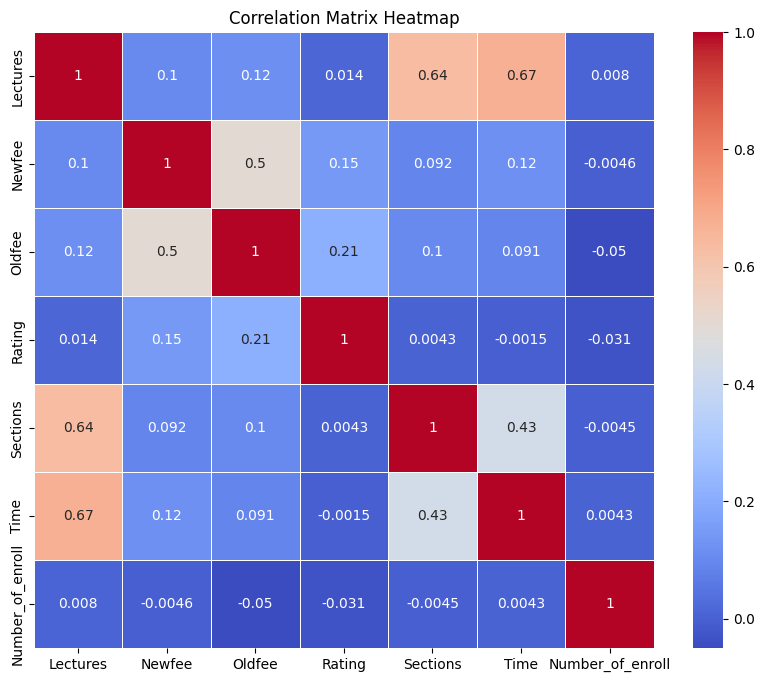

In [134]:
# Vẽ heatmap cho ma trận tương quan
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


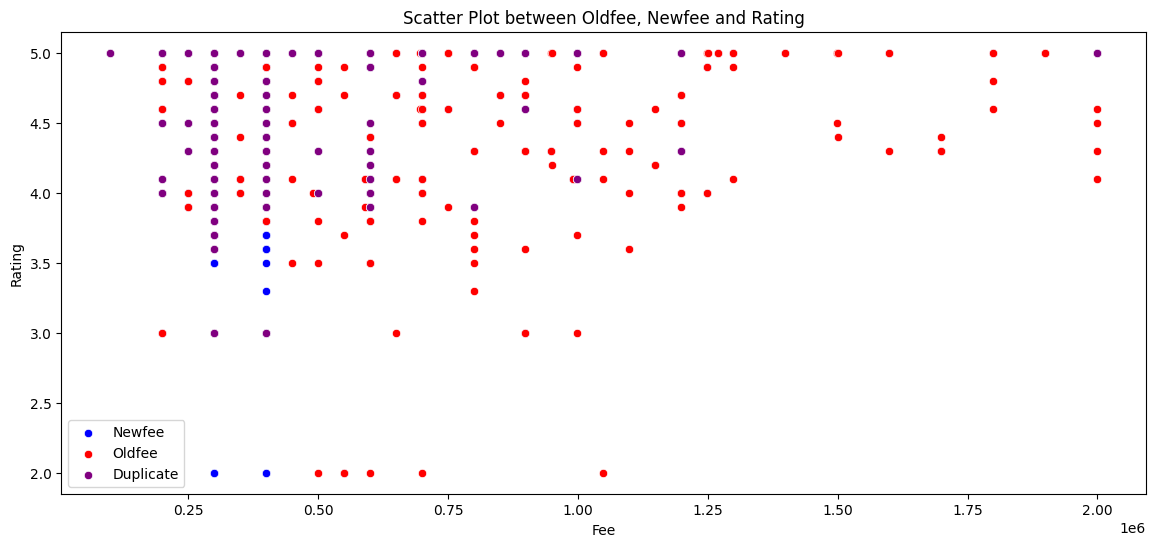

In [135]:

plt.figure(figsize=(14, 6))

# Xác định các điểm trùng nhau
df['is_duplicate'] = df.duplicated(subset=['Oldfee', 'Newfee', 'Rating'], keep=False)

# Vẽ scatter plot
sns.scatterplot(x='Newfee', y='Rating', data=df[df['is_duplicate'] == False], label="Newfee", color="blue")
sns.scatterplot(x='Oldfee', y='Rating', data=df[df['is_duplicate'] == False], label="Oldfee", color="red")
sns.scatterplot(x='Newfee', y='Rating', data=df[df['is_duplicate'] == True], label="Duplicate", color="purple")


# Cài đặt tiêu đề và nhãn
plt.title('Scatter Plot between Oldfee, Newfee and Rating')
plt.xlabel('Fee')
plt.ylabel('Rating')

# Hiển thị chú thích
plt.legend()

# Hiển thị biểu đồ
plt.show()


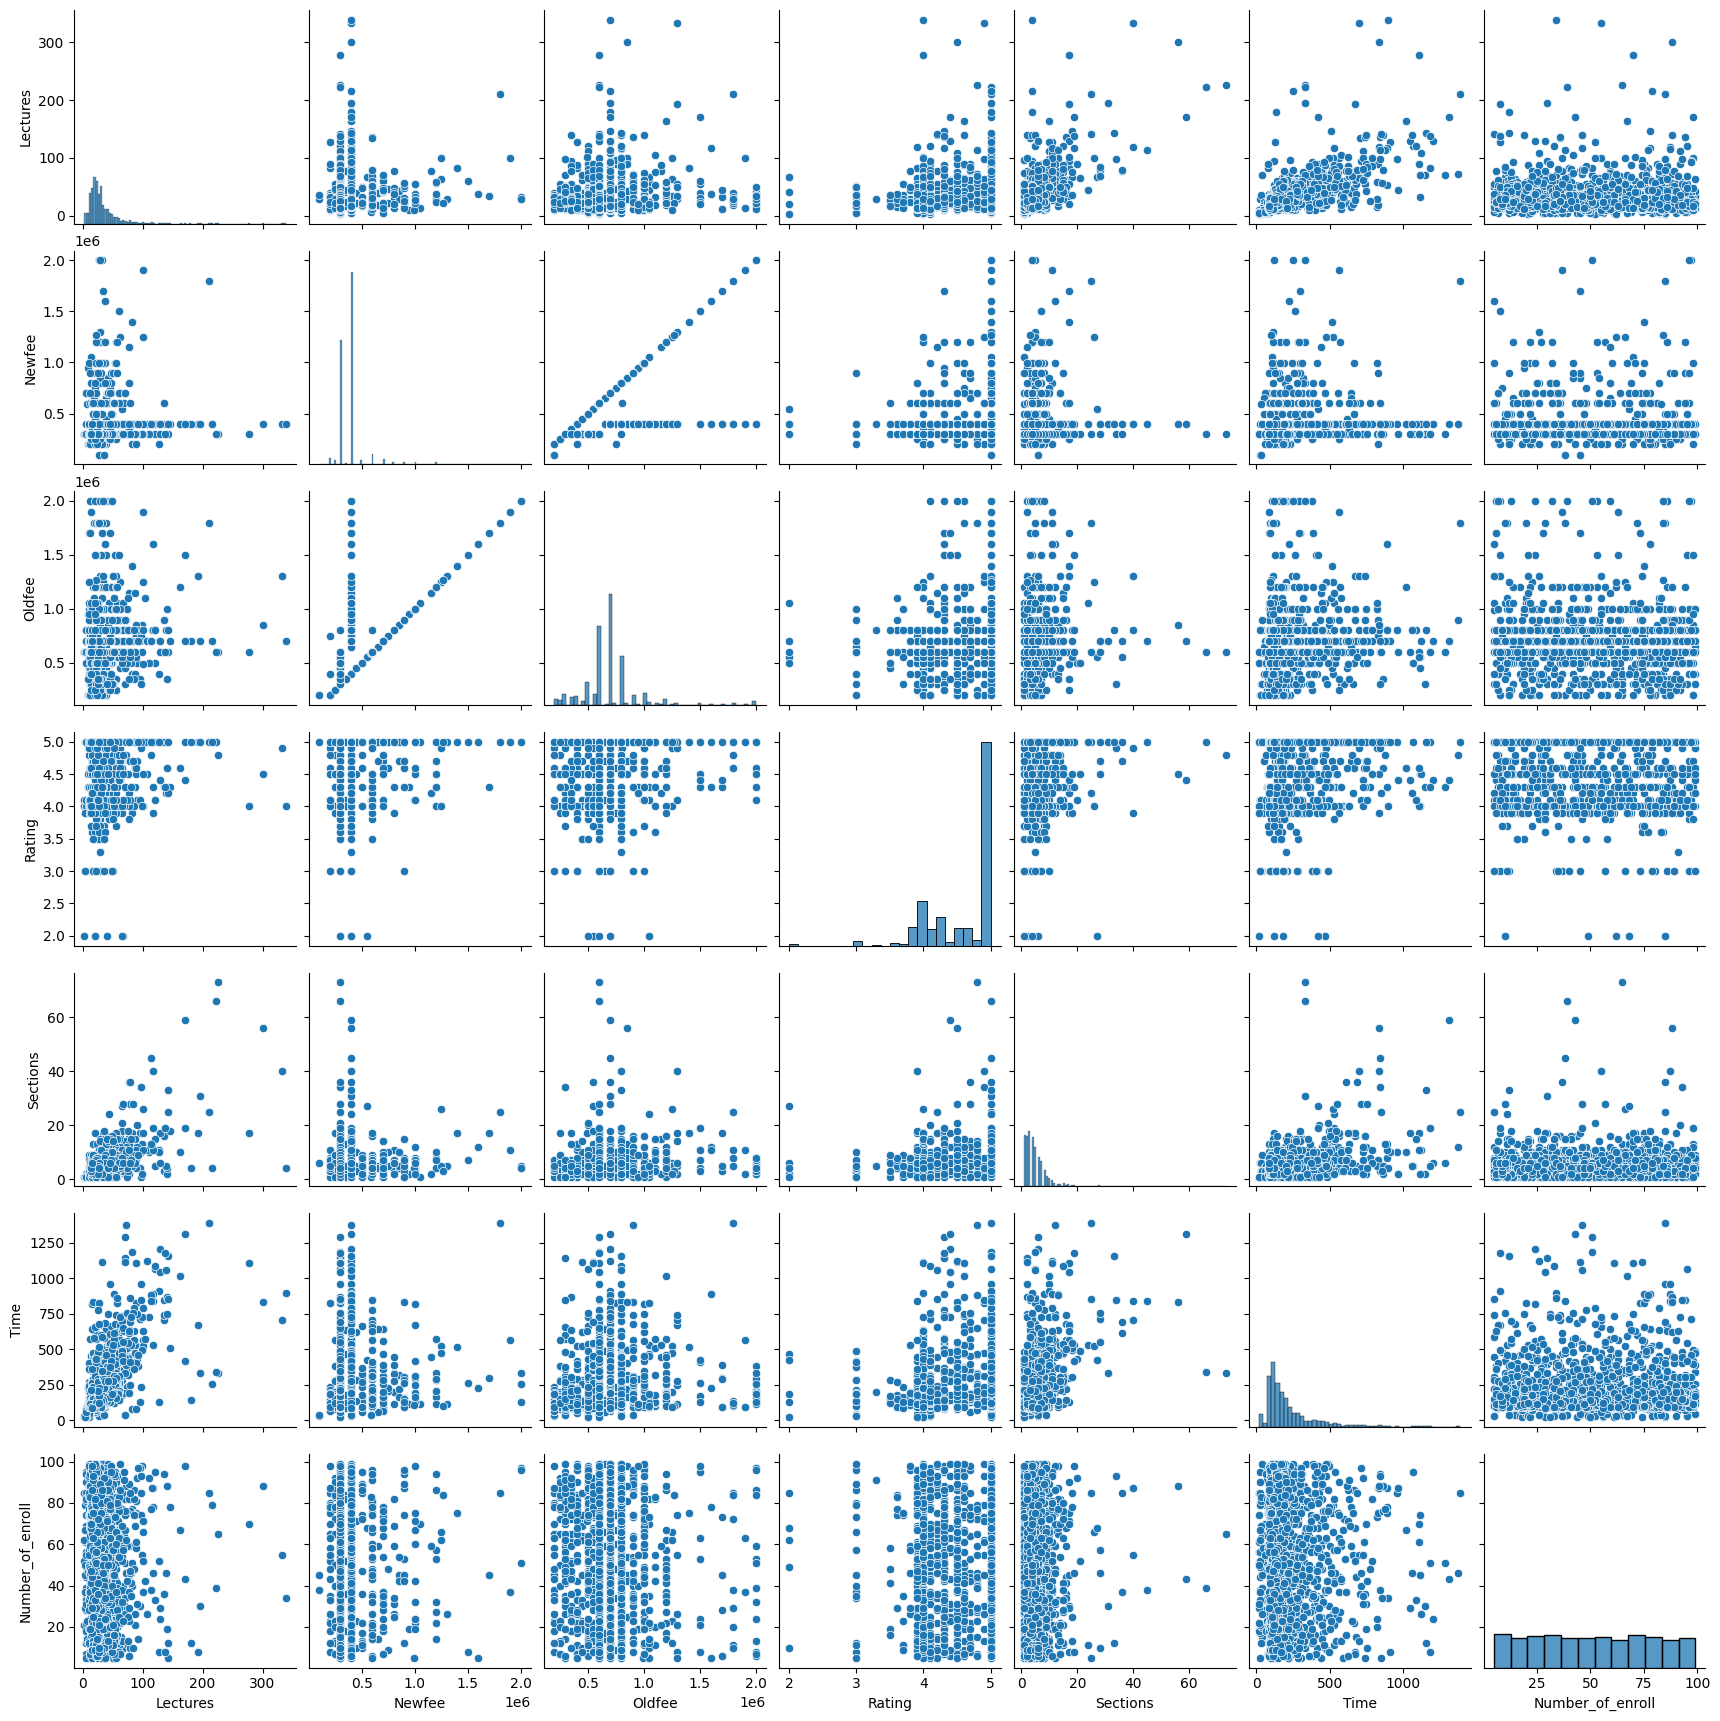

In [136]:
# Vẽ pair plot cho các biến số
sns.pairplot(df[['Lectures', 'Newfee', 'Oldfee', 'Rating', 'Sections', 'Time', 'Number_of_enroll']])
plt.show()


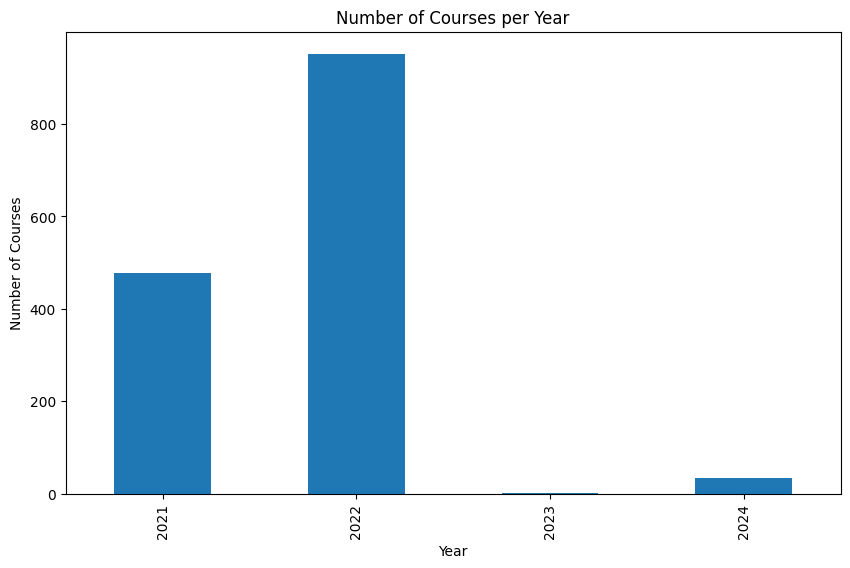

In [137]:
# Chuyển đổi cột Last_updated sang định dạng datetime
df['Last_updated'] = pd.to_datetime(df['Last_updated'])

# Nhóm dữ liệu theo năm và đếm số lượng khóa học
df['Year'] = df['Last_updated'].dt.year
courses_per_year = df.groupby('Year').size()

# Vẽ biểu đồ số lượng khóa học theo năm
plt.figure(figsize=(10, 6))
courses_per_year.plot(kind='bar')
plt.title('Number of Courses per Year')
plt.xlabel('Year')
plt.ylabel('Number of Courses')
plt.show()


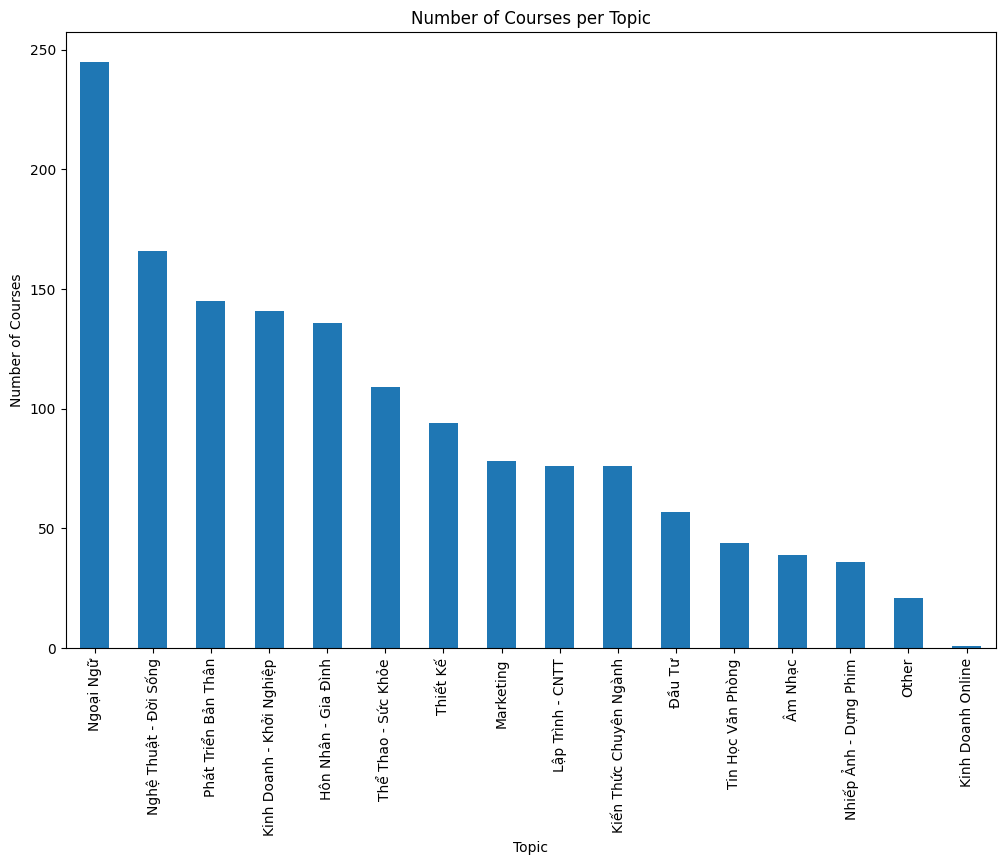

In [138]:
# Đếm số lượng khóa học theo chủ đề
courses_per_topic = df['Topic'].value_counts()

# Vẽ biểu đồ số lượng khóa học theo chủ đề
plt.figure(figsize=(12, 8))
courses_per_topic.plot(kind='bar')
plt.title('Number of Courses per Topic')
plt.xlabel('Topic')
plt.ylabel('Number of Courses')
plt.show()


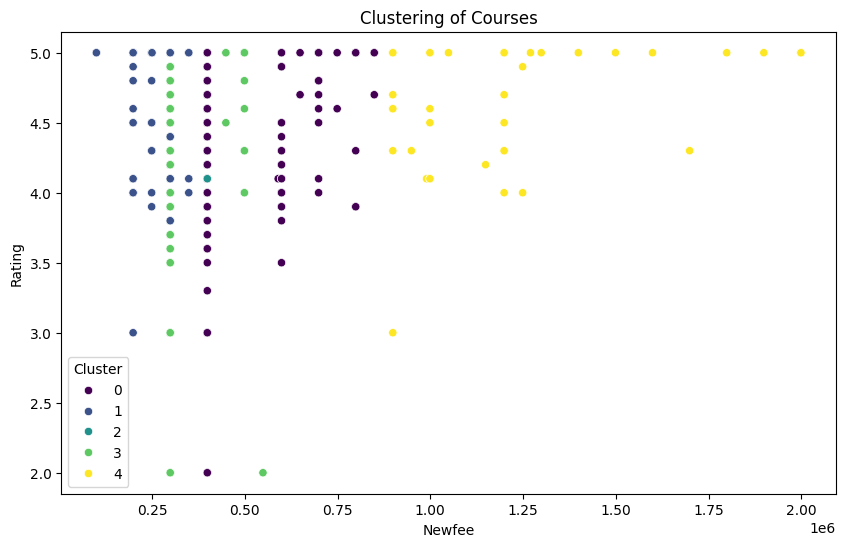

In [139]:
from sklearn.cluster import KMeans

# Chọn các cột số liệu để phân cụm
X = df[['Lectures', 'Newfee', 'Oldfee', 'Rating', 'Sections', 'Time']]

# Áp dụng K-means clustering
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)
df['Cluster'] = kmeans.labels_

# Vẽ biểu đồ phân cụm
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Newfee', y='Rating', hue='Cluster', data=df, palette='viridis')
plt.title('Clustering of Courses')
plt.xlabel('Newfee')
plt.ylabel('Rating')
plt.show()


In [140]:
X = df[["Lectures", 'Newfee', 'Oldfee', "Sections", "Time", "Number_of_enroll"]]
Y = df["Rating"]

X_train, X_test , y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state= 0)


In [141]:
# Xây dựng mô hình phân tích các giá trị của X ảnh hưởng như thế nào đến đánh giá của khóa học
# Sử dụng mô hình hồi quy tuyến tính

# Tạo mô hình hồi quy tuyến tính
regressor = LinearRegression()

# Huấn luyện mô hình
regressor.fit(X_train, y_train)

# Dự đoán giá trị
y_pred = regressor.predict(X_test)

# Tính toán các giá trị đánh giá
mse = mean_squared_error(y_test, y_pred) # độ lỗi bình phương trung bình
r2 = r2_score(y_test, y_pred) # hệ số xác định là 1 - (tổng bình phương của sai số / tổng bình phương của giá trị trung bình)
acc = regressor.score(X_test, y_test)
print("Mean Squared Error:", mse)
print("R2 Score:", r2)
print("Accuracy:", acc)
# với giá trị độ lỗi bình phương trung bình là 0.2634 và hệ số xác định là -0.01498
# chúng ta thấy rằng mô hình này không phù hợp với dữ liệu


Mean Squared Error: 0.26508535493232416
R2 Score: -0.021660899418495472
Accuracy: -0.021660899418495472


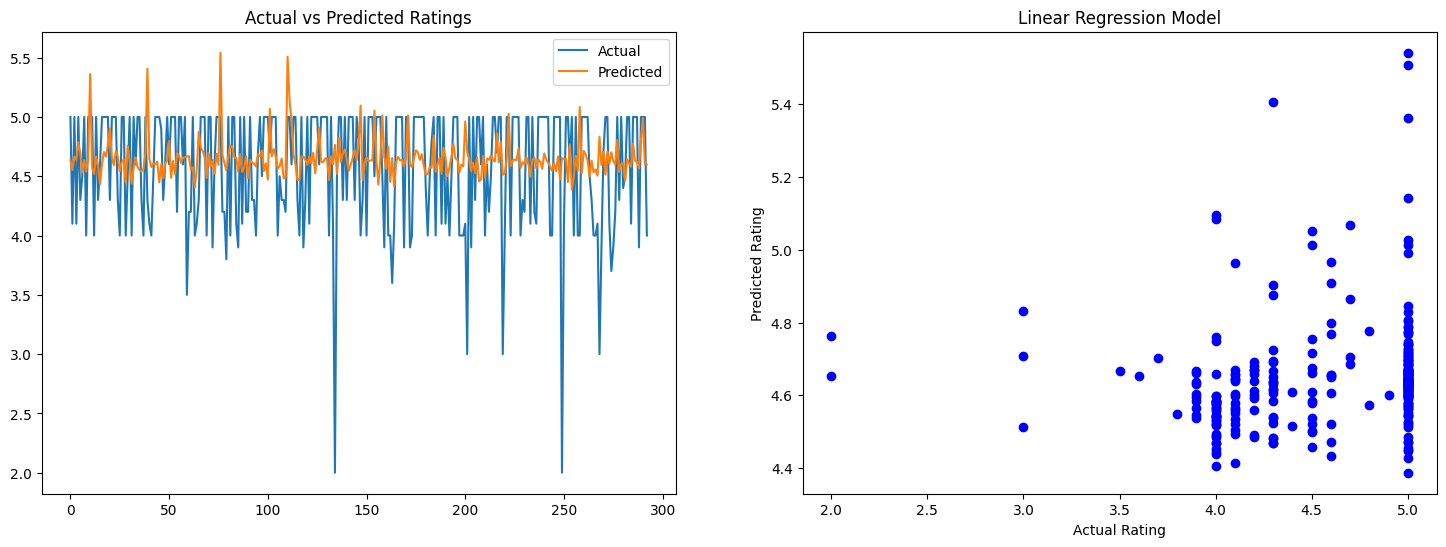

In [142]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Biểu đồ giá trị dự đoán và giá trị thực tế
ax[0].plot(y_test.values, label='Actual')
ax[0].plot(y_pred, label='Predicted')
ax[0].legend()
ax[0].set_title('Actual vs Predicted Ratings')

# Biểu đồ hóa dữ liệu của mô hình hồi quy tuyến tính với dữ liệu thực tế
ax[1].scatter(y_test, y_pred, color='blue')
ax[1].set_title('Linear Regression Model')
ax[1].set_xlabel('Actual Rating')
ax[1].set_ylabel('Predicted Rating')

plt.show()

# qua đó chúng ta thấy rằng mô hình này không phù hợp với dữ liệu
#  ở đây chúng ta sẽ sử dụng mô hình hồi quy logistic để dự đoán giá trị của biến phân loại
# và nhận xét rằng mô hình này phù hợp với dữ liệu vì dữ liệu tập trung nhiều ở giá trị 5*


In [143]:
df = pd.read_csv('/Users/hongviet/Documents/GitHub/Data-Analysis/GroupTask/edumall_cleaned4.csv')
df.dropna()


,Unnamed: 0,Author,Coursename,Last_updated,Lectures,Newfee,Oldfee,Rating,Sections,Time,Topic,Target,_id,Number_of_enroll
0,1,Edumall Learning,Thuyết trình chuyên nghiệp & ấn tượng,2024-08-08,28,99999.0,199999.0,5.0,6,28,Other,"['ôn tập kiến thức liên tục, tăng hiệu quả học...",66f79d3af050d8d70ad24671,38
1,2,Edumall Learning,Ứng tuyển thành công - Phỏng vấn hiệu quả,2024-04-26,36,99999.0,199999.0,5.0,6,36,Phát Triển Bản Thân,"['cung cấp kiến thức, kỹ năng & kinh nghiệm về...",66f79d3af050d8d70ad24672,45
2,3,Nguyễn Đình Hoa Cương,Procedural Python - Lập trình hàm trong Python,2024-07-03,82,199999.0,399999.0,5.0,8,78,Lập Trình - CNTT,"['nắm bắt sơ lược các khái niệm về hàm', 'thực...",66f79d3af050d8d70ad24673,77
3,4,Nguyễn Đình Hoa Cương,Python Basics - Python Cơ Bản,2022-11-02,128,199999.0,399999.0,5.0,11,126,Lập Trình - CNTT,"['cung cấp kiến thức, kỹ năng và phương pháp l...",66f79d3af050d8d70ad24674,52
4,5,Trần Thảo Vi,YOGA CHO BÀ BẦU - BÍ QUYẾT CHO MỘT THAI KỲ KHỎ...,2022-07-04,21,449000.0,449000.0,5.0,5,617,Thể Thao - Sức Khỏe,['tăng cường sức đề kháng giúp mẹ bầu có sức k...,66f79d3af050d8d70ad24675,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459,1494,Trần Thế Long,Yoga dưỡng sinh tại nhà,2021-12-15,14,299000.0,399000.0,5.0,3,209,Thể Thao - Sức Khỏe,['khóa học này giúp học viên có khả năng tự tr...,66f79d3af050d8d70ad24c46,68
1460,1495,Chu Thị Thanh Hương,Chiến lược dạy trẻ tự kỷ hồi phục,2022-05-17,14,299000.0,599000.0,4.0,4,91,Hôn Nhân - Gia Đình,['khóa học này tôi sẽ nói đến phương pháp son-...,66f79d3af050d8d70ad24c47,70
1461,1497,Hồ Thị Phương Anh,10 ngày trở thành chuyên gia tinh dầu chăm sóc...,2022-03-04,16,399000.0,699000.0,4.2,6,87,Hôn Nhân - Gia Đình,['học viên có được sức khỏe từ sử dụng thảo dư...,66f79d3af050d8d70ad24c49,29
1462,1498,Đỗ Trung Thành,Làm chủ Word 2016 từ cơ bản đến nâng cao,2022-06-10,43,399000.0,699000.0,4.5,4,275,Tin Học Văn Phòng,['cung cấp cho người học các kiến thức từ cơ b...,66f79d3af050d8d70ad24c4a,50


In [144]:

# Định nghĩa mô hình
rf = RandomForestRegressor()

# Định nghĩa các tham số cần tinh chỉnh
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Sử dụng GridSearchCV để tìm kiếm tham số tốt nhất
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# In ra tham số tốt nhất
print("Best parameters found: ", grid_search.best_params_)

# Sử dụng mô hình với tham số tốt nhất để dự đoán
best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)

# Đánh giá mô hình
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print('Mean Squared Error (RandomForest):', mse_rf)
print('R-squared (RandomForest):', r2_rf)

# Best parameters found:  {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
# Mean Squared Error (RandomForest): 0.23278503622743546
# R-squared (RandomForest): 0.10282720241559284
# đây là một giá trị tốt hơn so với mô hình hồi quy tuyến tính nhưng vẫn chưa phù hợp với dữ liệu
#  chúng ta có thể thử với một số mô hình khác và tinh chỉnh tham số để tìm ra mô hình phù hợp nhất với dữ liệu


Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END m

In [145]:
# Handle missing values
df = df.dropna()

# Convert data types
df['Lectures'] = df['Lectures'].astype(int)
df['Newfee'] = df['Newfee'].astype(float)
df['Oldfee'] = df['Oldfee'].astype(float)
df['Sections'] = df['Sections'].astype(int)
df['Time'] = df['Time'].astype(int)
df['Rating'] = df['Rating'].astype(float)
df['Number_of_enroll'] = df['Number_of_enroll'].astype(int)

scaler = StandardScaler()
df[['Lectures', 'Newfee', 'Oldfee', 'Sections', 'Time', 'Rating', 'Number_of_enroll']] = scaler.fit_transform(df[['Lectures', 'Newfee', 'Oldfee', 'Sections', 'Time', 'Rating', 'Number_of_enroll']])

# hiển thị dữ liệu sau khi xử lý
df.shape



(1464, 14)

In [146]:

# Chuyển đổi 'Last_updated' thành timestamp và tính số ngày từ ngày cập nhật gần nhất
df['Last_updated'] = pd.to_datetime(df['Last_updated'])
df['Days_since_update'] = (pd.Timestamp('2024-08-08') - df['Last_updated']).dt.days


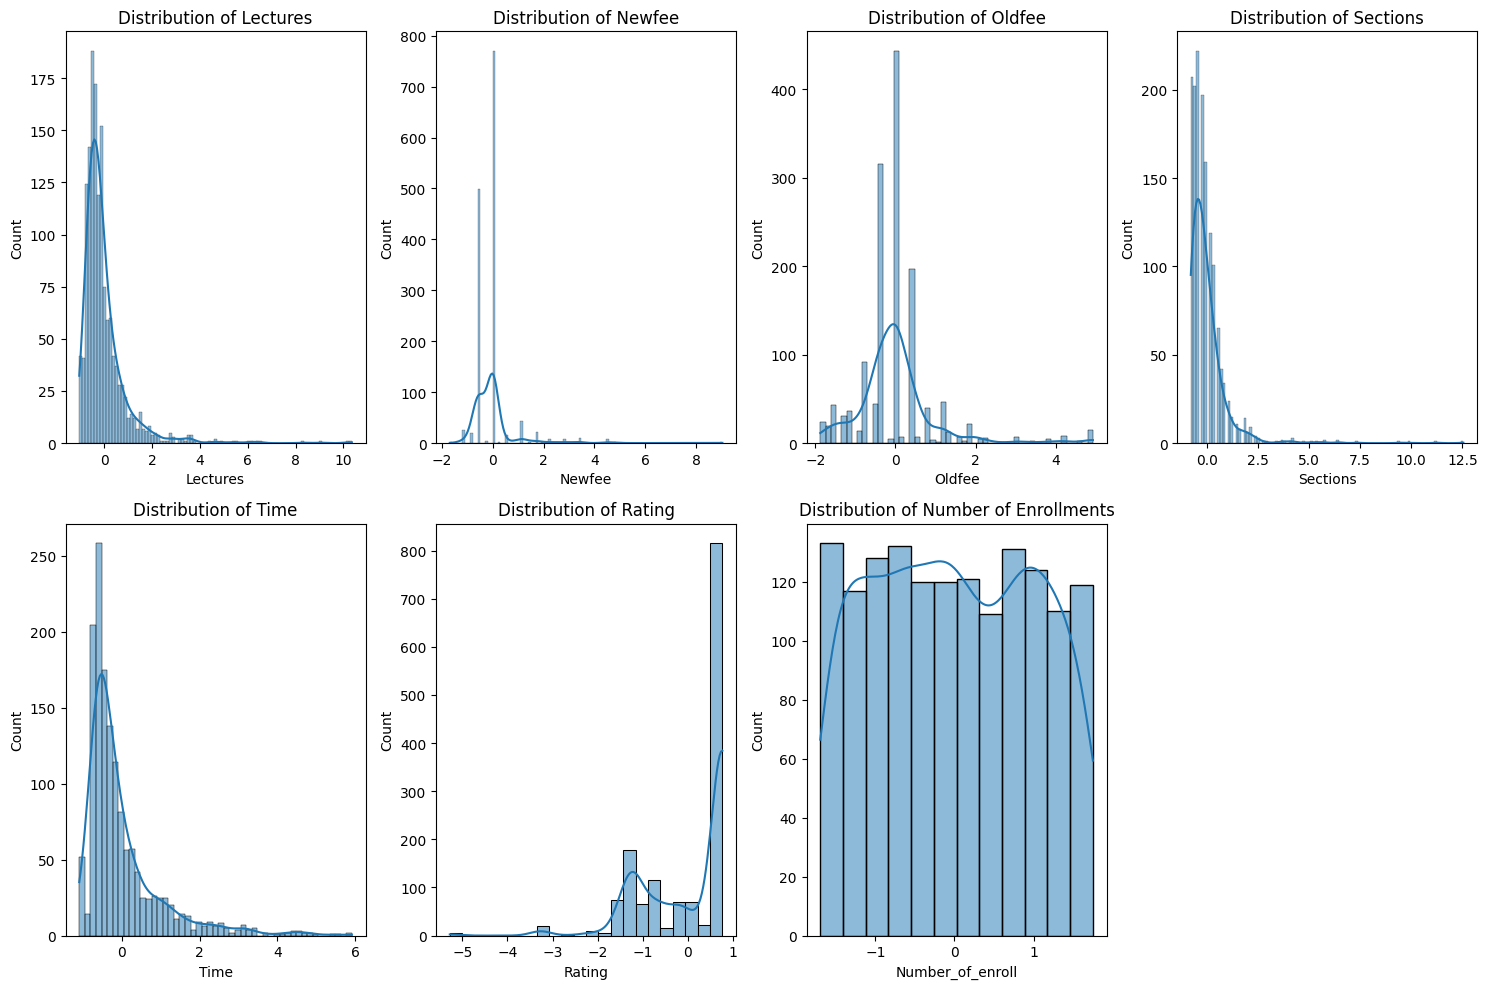

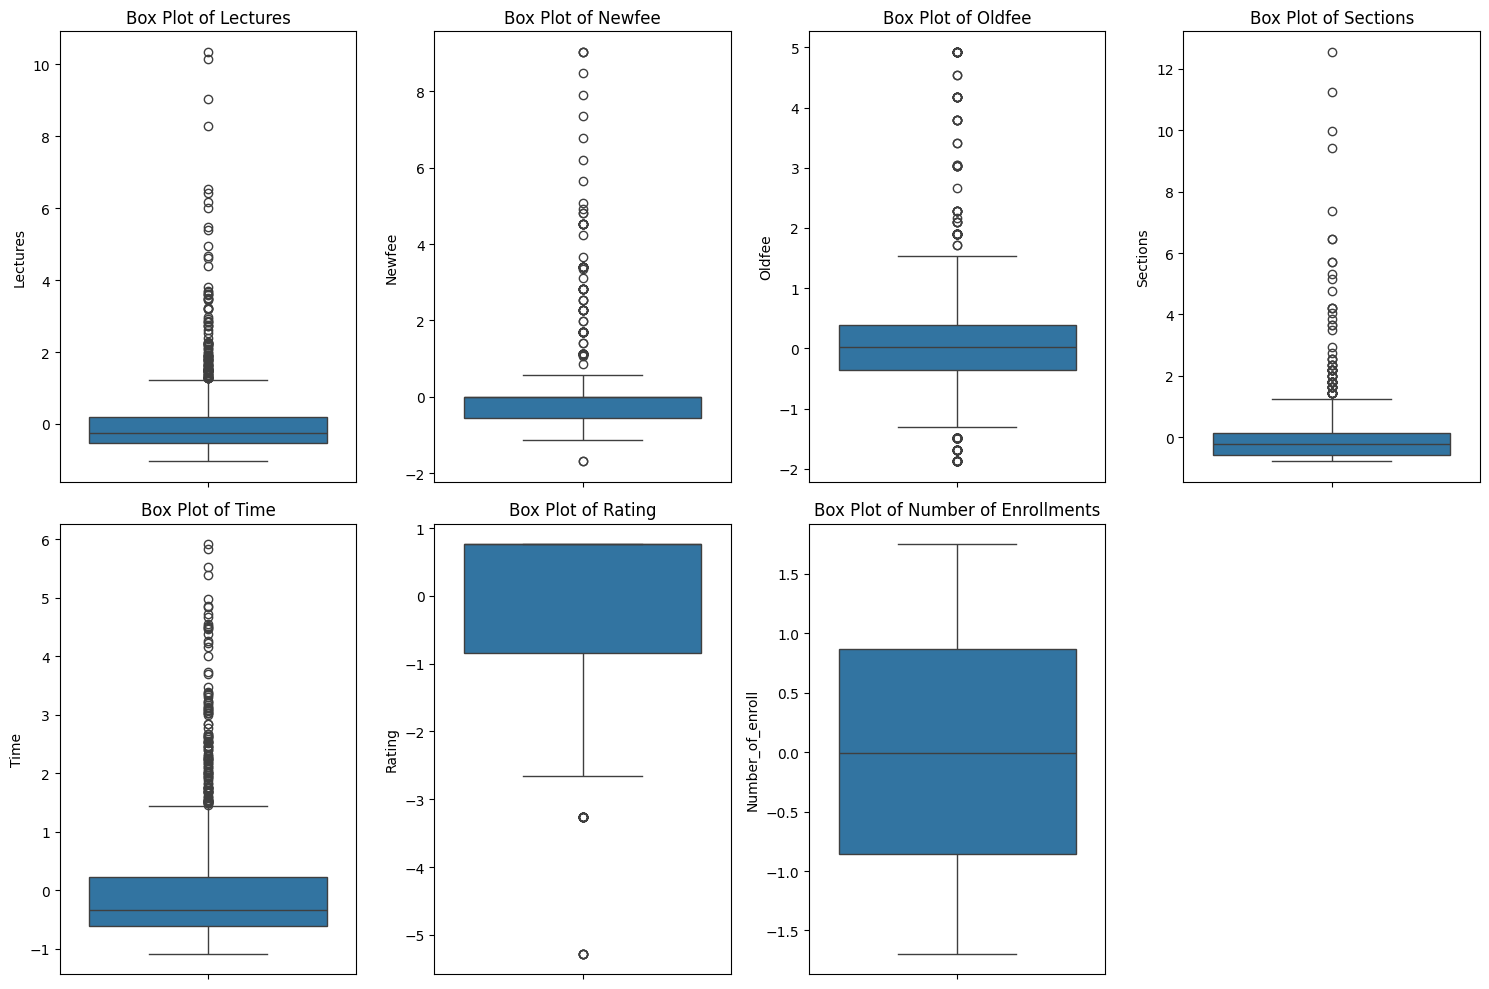

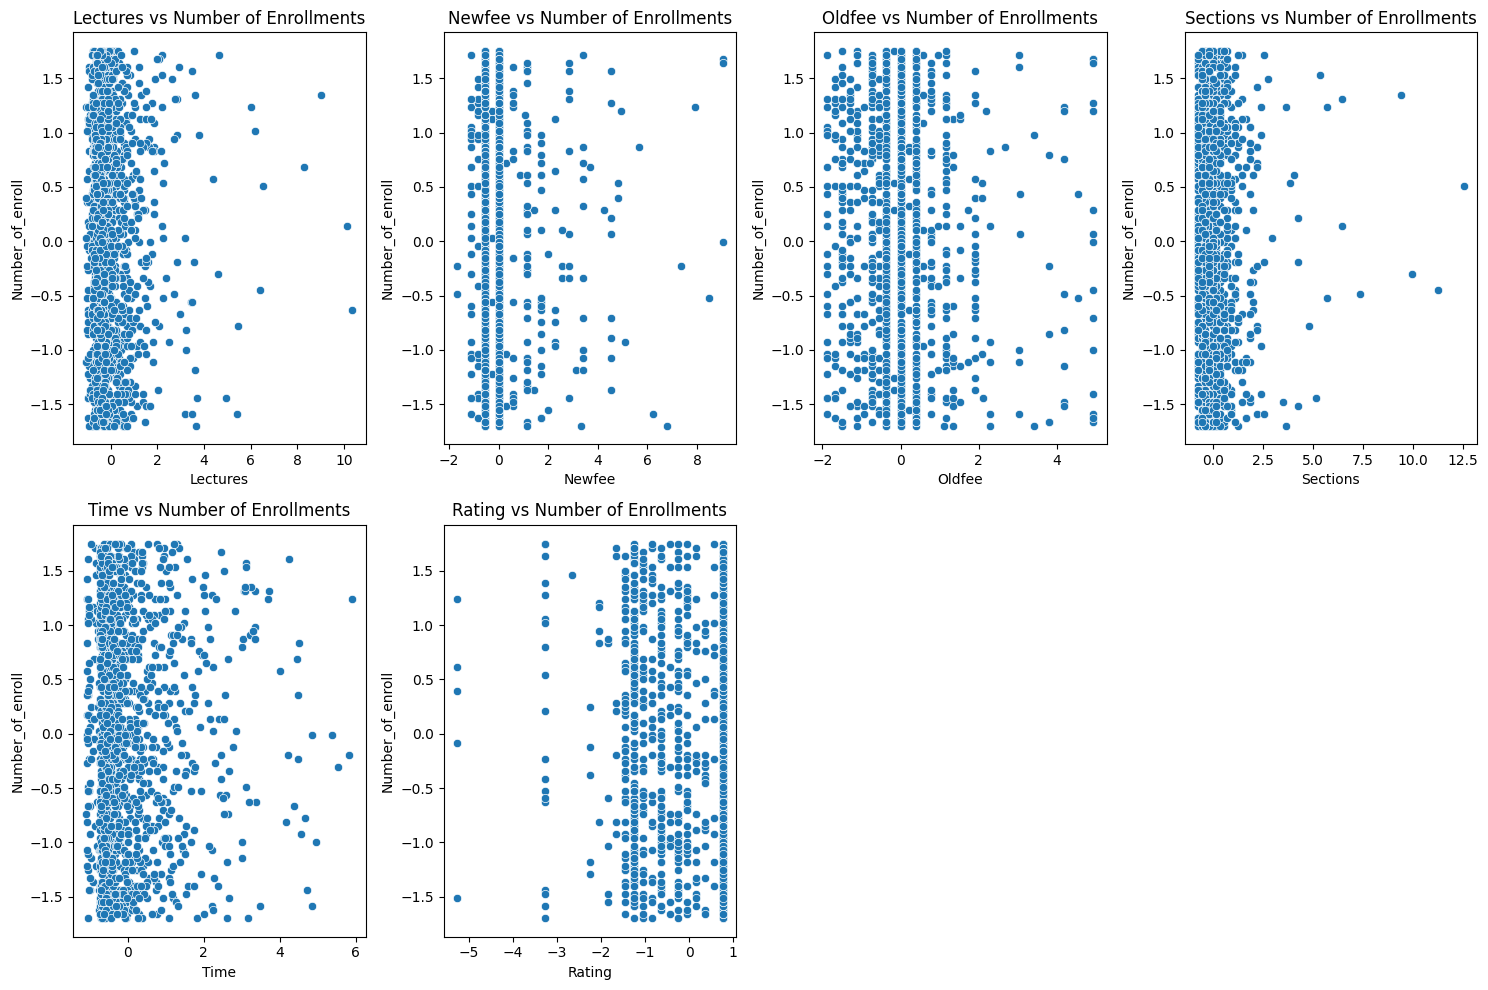

In [147]:
# Trực quan hóa dữ liệu theo kiểu histogram
plt.figure(figsize=(15, 10))

plt.subplot(2, 4, 1)
sns.histplot(df['Lectures'], kde=True)
plt.title('Distribution of Lectures')

plt.subplot(2, 4, 2)
sns.histplot(df['Newfee'], kde=True)
plt.title('Distribution of Newfee')

plt.subplot(2, 4, 3)
sns.histplot(df['Oldfee'], kde=True)
plt.title('Distribution of Oldfee')

plt.subplot(2, 4, 4)
sns.histplot(df['Sections'], kde=True)
plt.title('Distribution of Sections')

plt.subplot(2, 4, 5)
sns.histplot(df['Time'], kde=True)
plt.title('Distribution of Time')

plt.subplot(2, 4, 6)
sns.histplot(df['Rating'], kde=True)
plt.title('Distribution of Rating')

plt.subplot(2, 4, 7)
sns.histplot(df['Number_of_enroll'], kde=True)
plt.title('Distribution of Number of Enrollments')

plt.tight_layout()
plt.show()

# Visualize sự phân bố của các biến số theo box plot để xác định các giá trị ngoại lệ
plt.figure(figsize=(15, 10))

plt.subplot(2, 4, 1)
sns.boxplot(y=df['Lectures'])
plt.title('Box Plot of Lectures')

plt.subplot(2, 4, 2)
sns.boxplot(y=df['Newfee'])
plt.title('Box Plot of Newfee')

plt.subplot(2, 4, 3)
sns.boxplot(y=df['Oldfee'])
plt.title('Box Plot of Oldfee')

plt.subplot(2, 4, 4)
sns.boxplot(y=df['Sections'])
plt.title('Box Plot of Sections')

plt.subplot(2, 4, 5)
sns.boxplot(y=df['Time'])
plt.title('Box Plot of Time')

plt.subplot(2, 4, 6)
sns.boxplot(y=df['Rating'])
plt.title('Box Plot of Rating')

plt.subplot(2, 4, 7)
sns.boxplot(y=df['Number_of_enroll'])
plt.title('Box Plot of Number of Enrollments')

plt.tight_layout()
plt.show()

# Visualize mối quan hệ giữa các số lượng học viên đăng ký và các biến số khác
plt.figure(figsize=(15, 10))

plt.subplot(2, 4, 1)
sns.scatterplot(x=df['Lectures'], y=df['Number_of_enroll'])
plt.title('Lectures vs Number of Enrollments')

plt.subplot(2, 4, 2)
sns.scatterplot(x=df['Newfee'], y=df['Number_of_enroll'])
plt.title('Newfee vs Number of Enrollments')

plt.subplot(2, 4, 3)
sns.scatterplot(x=df['Oldfee'], y=df['Number_of_enroll'])
plt.title('Oldfee vs Number of Enrollments')

plt.subplot(2, 4, 4)
sns.scatterplot(x=df['Sections'], y=df['Number_of_enroll'])
plt.title('Sections vs Number of Enrollments')

plt.subplot(2, 4, 5)
sns.scatterplot(x=df['Time'], y=df['Number_of_enroll'])
plt.title('Time vs Number of Enrollments')

plt.subplot(2, 4, 6)
sns.scatterplot(x=df['Rating'], y=df['Number_of_enroll'])
plt.title('Rating vs Number of Enrollments')

plt.tight_layout()
plt.show()


In [148]:
# qua kết quả của những bản trên:
# thứ nhất về mặc biểu đồ histogram thì ta thấy rằng các biến đều có phân phối chuẩn (normal distribution) riêng Rating thì có phân phối lệch phải
# thứ hai về box plot thì ta thấy rằng ngoài giá trị của Rating có outliers thì các giá trị còn lại đều liền lạc
# thứ ba về scatter plot thì ta thấy rằng có một số biến có mối quan hệ tuyến tính với biến Number_of_enrollers như Lectures, Newfee, Oldfee, Sections, Time, Rating
# cơ bản trong các giá trị như vậy thì độ liên quan này cso thể giúp ta dự đoán giá trị của biến Number_of_enrollers
# nhưng cũng có một số biến không có mối quan hệ tuyến tính với biến Number_of_enrollers nhưng ta vẫn giữ lại để xem xét
# có thể sẽ loại bỏ sau khi xây dựng mô hình


Number_of_enroll     1.000000
Days_since_update    0.017112
Lectures             0.008044
Time                 0.004268
Sections            -0.004452
Newfee              -0.004582
Rating              -0.030916
Oldfee              -0.050459
Name: Number_of_enroll, dtype: float64


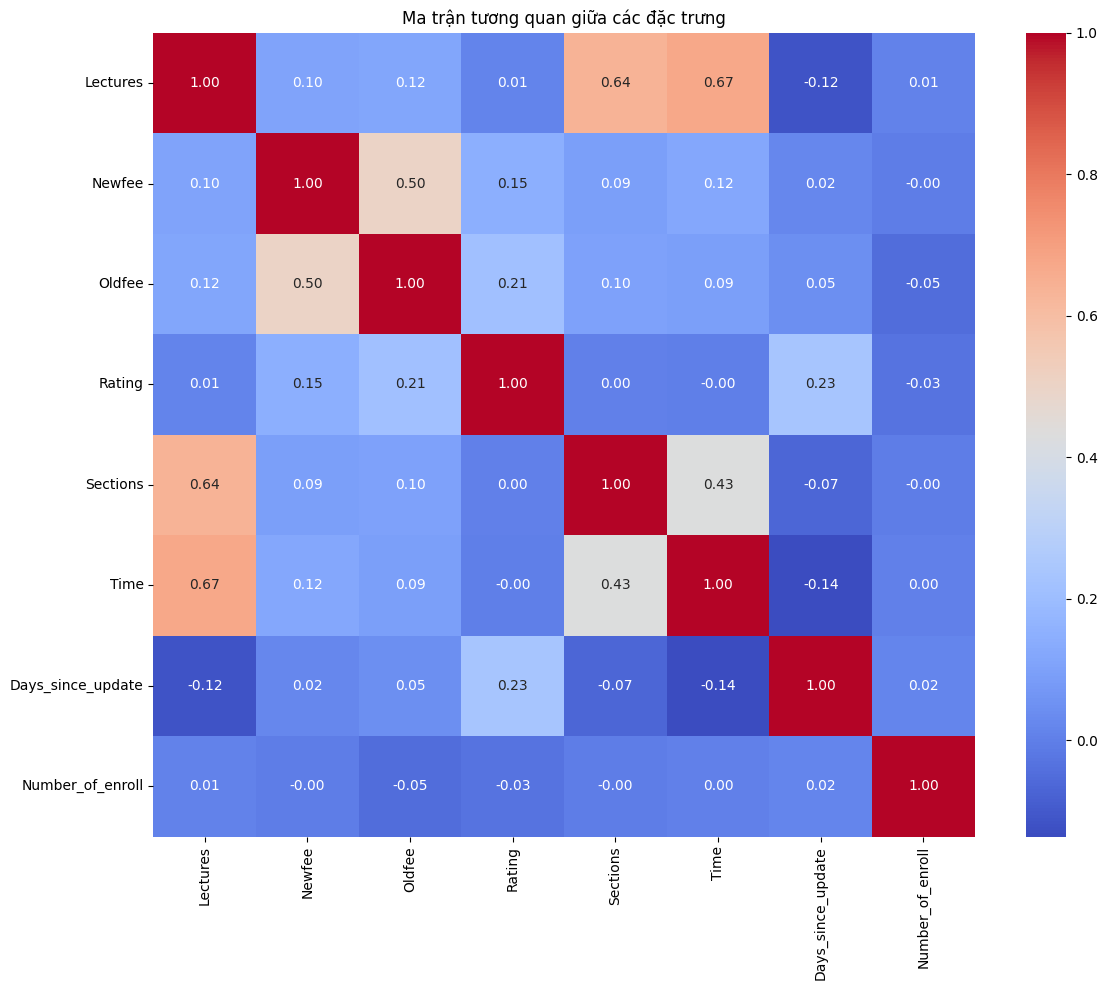

In [149]:
corr_features = ['Lectures', 'Newfee', 'Oldfee', 'Rating', 'Sections', 'Time', 'Days_since_update', 'Number_of_enroll']
correlation = df[corr_features].corr()
print(correlation['Number_of_enroll'].sort_values(ascending=False))

# Vẽ heatmap tương quan
plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Ma trận tương quan giữa các đặc trưng")
plt.tight_layout()
plt.show()


Tương quan của các đặc trưng với Số lượng đăng ký:
 Number_of_enroll    1.000000
Lectures            0.008044
Time                0.004268
Sections           -0.004452
Newfee             -0.004582
Rating             -0.030916
Oldfee             -0.050459
Name: Number_of_enroll, dtype: float64
Các đặc trưng được chọn dựa trên tương quan:
 []
Tầm quan trọng của đặc trưng dựa trên Hồi quy tuyến tính:
 Time        0.033362
Newfee      0.020024
Lectures    0.010537
Rating     -0.010303
Sections   -0.030966
Oldfee     -0.072699
dtype: float64


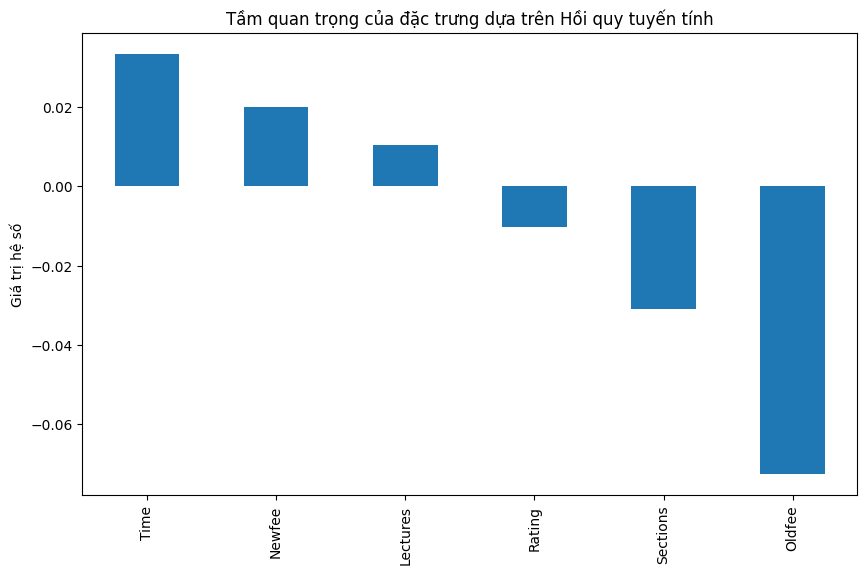

In [150]:
# Lựa chọn đặc trưng

# Chọn các đặc trưng liên quan nhất dựa trên phân tích tương quan và các kỹ thuật lựa chọn đặc trưng khác

# Hiển thị giá trị tương quan của mỗi đặc trưng với biến mục tiêu
correlation_with_target = correlation_matrix['Number_of_enroll'].sort_values(ascending=False)
print("Tương quan của các đặc trưng với Số lượng đăng ký:\n", correlation_with_target)

# Chọn các đặc trưng có tương quan cao với biến mục tiêu
selected_features = correlation_with_target[correlation_with_target.abs() > 0.5].index.tolist()
selected_features.remove('Number_of_enroll')  # Loại bỏ biến mục tiêu khỏi danh sách
print("Các đặc trưng được chọn dựa trên tương quan:\n", selected_features)

# Đảm bảo selected_features không rỗng
if not selected_features:
    selected_features = correlation_with_target.index.tolist()
    selected_features.remove('Number_of_enroll')

# Tầm quan trọng của đặc trưng sử dụng Hồi quy tuyến tính
X = df[selected_features]
y = df['Number_of_enroll']

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Huấn luyện mô hình Hồi quy tuyến tính
model = LinearRegression()
model.fit(X_train, y_train)

# Lấy tầm quan trọng của đặc trưng (hệ số)
feature_importance = pd.Series(model.coef_, index=selected_features).sort_values(ascending=False)
print("Tầm quan trọng của đặc trưng dựa trên Hồi quy tuyến tính:\n", feature_importance)

# Hiển thị tầm quan trọng của đặc trưng
plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar')
plt.title('Tầm quan trọng của đặc trưng dựa trên Hồi quy tuyến tính')
plt.ylabel('Giá trị hệ số')
plt.show()


+ Time (Thời gian): Có hệ số dương lớn nhất (khoảng 0,03), cho thấy thời gian có tác động tích cực mạnh nhất đến biến phụ thuộc.
+ NewFee (Phí mới): Có hệ số dương (khoảng 0,02), thể hiện tác động tích cực vừa phải.
+ Lectures (Bài giảng): Có hệ số dương nhỏ hơn (khoảng 0,01), cũng thể hiện tác động tích cực nhưng ít hơn.
+ Rating (Đánh giá) và Sections (Phần): Cả hai đều có hệ số âm nhỏ (khoảng -0,01), thể hiện tác động tiêu cực nhẹ.
+ OldFee (Phí cũ): Có hệ số âm lớn nhất (khoảng -0,07), cho thấy tác động tiêu cực mạnh nhất.

- Time có ảnh hưởng tích cực mạnh nhất đến kết quả dự đoán
- OldFee có ảnh hưởng tiêu cực mạnh nhất


Hồi quy tuyến tính - Sai số bình phương trung bình: 1.031594185534172
Hồi quy tuyến tính - Hệ số R-bình phương: -0.009974578248217014
Rừng ngẫu nhiên - Sai số bình phương trung bình: 1.0753670977795322
Rừng ngẫu nhiên - Hệ số R-bình phương: -0.0528301208672477


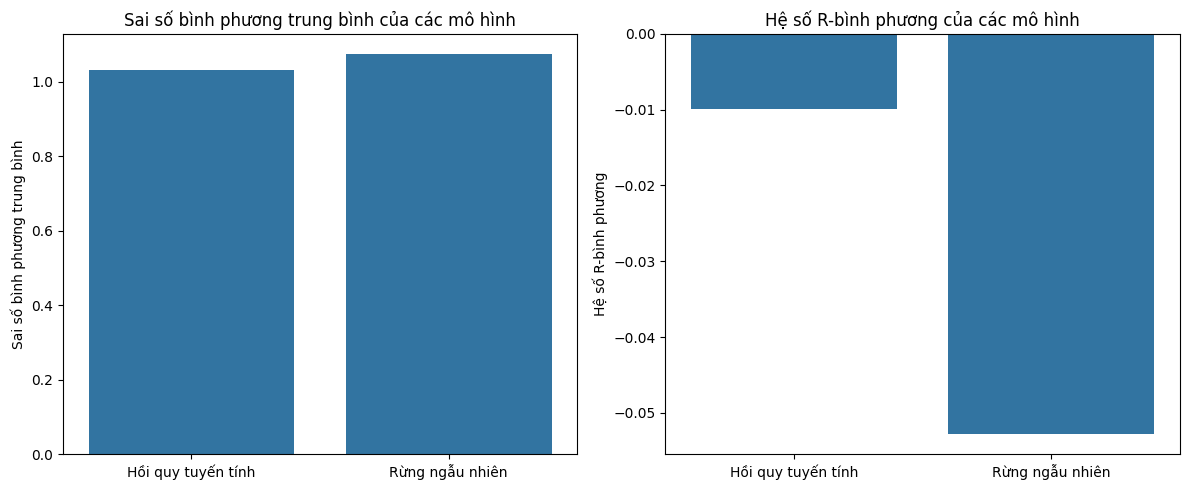

In [151]:
# Huấn luyện mô hình Hồi quy tuyến tính
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred_linear = linear_model.predict(X_test)

# Đánh giá mô hình Hồi quy tuyến tính
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)
print(f"Hồi quy tuyến tính - Sai số bình phương trung bình: {mse_linear}")
print(f"Hồi quy tuyến tính - Hệ số R-bình phương: {r2_linear}")


rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred_rf = rf_model.predict(X_test)

# Đánh giá mô hình Rừng ngẫu nhiên
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Rừng ngẫu nhiên - Sai số bình phương trung bình: {mse_rf}")
print(f"Rừng ngẫu nhiên - Hệ số R-bình phương: {r2_rf}")

# Trực quan hóa hiệu suất của cả hai mô hình
models = ['Hồi quy tuyến tính', 'Rừng ngẫu nhiên']
mse_values = [mse_linear, mse_rf]
r2_values = [r2_linear, r2_rf]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.barplot(x=models, y=mse_values)
plt.title('Sai số bình phương trung bình của các mô hình')
plt.ylabel('Sai số bình phương trung bình')

plt.subplot(1, 2, 2)
sns.barplot(x=models, y=r2_values)
plt.title('Hệ số R-bình phương của các mô hình')
plt.ylabel('Hệ số R-bình phương')

plt.tight_layout()
plt.show()


In [152]:

# 1. Định nghĩa mô hình DNN cải tiến
class ImprovedDNN(nn.Module):
    def __init__(self, input_size, hidden_sizes=[64, 128, 256, 512, 128, 64], dropout_rate=0.2):
        super(ImprovedDNN, self).__init__()
        
        # Tạo danh sách các lớp
        layers = []
        
        # Lớp đầu vào
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.BatchNorm1d(hidden_sizes[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.BatchNorm1d(hidden_sizes[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate)) # ngăn ngừa overfitting
        
        # Các lớp ẩn
        for i in range(len(hidden_sizes)-1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            layers.append(nn.BatchNorm1d(hidden_sizes[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
        
        # Lớp đầu ra
        layers.append(nn.Linear(hidden_sizes[-1], 1))
        
        # Kết hợp tất cả các lớp
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)



In [153]:
# 2. Hàm huấn luyện và đánh giá mô hình
def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, 
                            epochs=250, batch_size=16, lr=0.001, weight_decay=0.0001):
    
    # Chuyển đổi dữ liệu sang tensor
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
    X_val_tensor = torch.FloatTensor(X_val)
    y_val_tensor = torch.FloatTensor(y_val).reshape(-1, 1)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.FloatTensor(y_test).reshape(-1, 1)
    
    # Tạo dataset và dataloader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    # Hàm mất mát và tối ưu hóa
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    
    # Lưu lịch sử huấn luyện
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_r2': [],
        'val_r2': [],
        'train_mae': [],
        'val_mae': []
    }
    
    # Huấn luyện mô hình
    for epoch in range(epochs):
        # --- Pha huấn luyện ---
        model.train()
        train_loss = 0.0
        train_outputs = []
        train_targets = []
        
        for inputs, targets in train_loader:
            optimizer.zero_grad() # Đặt lại gradient của tất cả tham số về 0 trước mỗi bước cập nhật. 
                                # Bước này rất quan trọng vì PyTorch tích lũy gradient theo mặc định, nếu không có dòng này, 
                                # gradient từ các batch trước sẽ ảnh hưởng đến cập nhật hiện tại.
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step() #Bộ tối ưu hóa (optimizer) sử dụng gradient đã tính để cập nhật các tham số của mô hình theo thuật toán đã chọn (ở đây là Adam).
            
            train_loss += loss.item()
            train_outputs.extend(outputs.detach().numpy()) # tách tensor khỏi đồ thị tính toán trước khi chuyển đổi sang NumPy để tiết kiệm bộ nhớ.
            train_targets.extend(targets.numpy())
        
        train_loss /= len(train_loader)
        train_r2 = r2_score(train_targets, train_outputs)
        train_mae = mean_absolute_error(train_targets, train_outputs)
        
        # --- Pha đánh giá ---
        model.eval()
        val_loss = 0.0
        val_outputs = []
        val_targets = []
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
                val_outputs.extend(outputs.numpy())
                val_targets.extend(targets.numpy())
        
        val_loss /= len(val_loader)
        val_r2 = r2_score(val_targets, val_outputs)
        val_mae = mean_absolute_error(val_targets, val_outputs)
        
        # Cập nhật lịch sử
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_r2'].append(train_r2)
        history['val_r2'].append(val_r2)
        history['train_mae'].append(train_mae)
        history['val_mae'].append(val_mae)
        
        # Cập nhật learning rate
        scheduler.step(val_loss)
        
        # In thông tin mỗi 20 epochs
        if (epoch + 1) % 20 == 0:
            print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train R²: {train_r2:.4f}, Val R²: {val_r2:.4f}')
    
    # Đánh giá mô hình trên tập test
    model.eval()
    test_outputs = []
    test_targets = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            test_outputs.extend(outputs.numpy())
            test_targets.extend(targets.numpy())
    
    test_mse = mean_squared_error(test_targets, test_outputs)
    test_r2 = r2_score(test_targets, test_outputs)
    test_mae = mean_absolute_error(test_targets, test_outputs)
    
    results = {
        'history': history,
        'test_metrics': {
            'mse': test_mse,
            'r2': test_r2,
            'mae': test_mae
        }
    }
    
    return results


In [154]:

# 3. Hàm vẽ biểu đồ phân tích overfitting/underfitting
def plot_model_performance(models_results, model_names):
    """
    Vẽ biểu đồ so sánh hiệu suất của các mô hình
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Biểu đồ Loss
    for i, (result, name) in enumerate(zip(models_results, model_names)):
        history = result['history']
        axes[0, 0].plot(history['train_loss'], linestyle='-', alpha=0.7, label=f'{name} - Train')
        axes[0, 0].plot(history['val_loss'], linestyle='--', alpha=0.7, label=f'{name} - Val')
    
    axes[0, 0].set_title('So sánh Loss qua các epochs', fontsize=14)
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Loss (MSE)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Biểu đồ R²
    for i, (result, name) in enumerate(zip(models_results, model_names)):
        history = result['history']
        axes[0, 1].plot(history['train_r2'], linestyle='-', alpha=0.7, label=f'{name} - Train')
        axes[0, 1].plot(history['val_r2'], linestyle='--', alpha=0.7, label=f'{name} - Val')
    
    axes[0, 1].set_title('So sánh R² qua các epochs', fontsize=14)
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('R²')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Biểu đồ MAE
    for i, (result, name) in enumerate(zip(models_results, model_names)):
        history = result['history']
        axes[1, 0].plot(history['train_mae'], linestyle='-', alpha=0.7, label=f'{name} - Train')
        axes[1, 0].plot(history['val_mae'], linestyle='--', alpha=0.7, label=f'{name} - Val')
    
    axes[1, 0].set_title('So sánh MAE qua các epochs', fontsize=14)
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('MAE')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Biểu đồ so sánh các độ đo trên tập test
    metrics = ['mse', 'mae', 'r2']
    model_test_metrics = []
    
    for result in models_results:
        model_test_metrics.append([
            result['test_metrics']['mse'],
            result['test_metrics']['mae'],
            result['test_metrics']['r2']
        ])
    
    x = np.arange(len(metrics))
    width = 0.2
    
    for i, (metrics_values, name) in enumerate(zip(model_test_metrics, model_names)):
        axes[1, 1].bar(x + i*width, metrics_values, width, label=name)
    
    axes[1, 1].set_title('So sánh độ đo trên tập test', fontsize=14)
    axes[1, 1].set_xticks(x + width)
    axes[1, 1].set_xticklabels(metrics)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


In [155]:

# 4. Chạy thí nghiệm với 3 mô hình khác nhau (underfitting, balanced, overfitting)
def run_experiments(X_train, y_train, X_val, y_val, X_test, y_test):
    input_size = X_train.shape[1]
    
    # Mô hình 1: Đơn giản (có thể underfitting)
    model_simple = ImprovedDNN(
        input_size=input_size,
        hidden_sizes=[32, 32],
        dropout_rate=0.1
    )
    
    # Mô hình 2: Cân bằng (balanced)
    model_balanced = ImprovedDNN(
        input_size=input_size,
        hidden_sizes=[64, 128, 64],
        dropout_rate=0.2
    )
    
    # Mô hình 3: Phức tạp (có thể overfitting)
    model_complex = ImprovedDNN(
        input_size=input_size,
        hidden_sizes=[128, 256,512, 256, 128],
        dropout_rate=0.0  # Không có dropout -> dễ overfitting
    )
    
    # Huấn luyện và đánh giá các mô hình
    print("Huấn luyện mô hình đơn giản...")
    results_simple = train_and_evaluate_model(
        model_simple, X_train, y_train, X_val, y_val, X_test, y_test,
        epochs=200, batch_size=32, lr=0.001, weight_decay=0.0001
    )
    
    print("\nHuấn luyện mô hình cân bằng...")
    results_balanced = train_and_evaluate_model(
        model_balanced, X_train, y_train, X_val, y_val, X_test, y_test,
        epochs=250, batch_size=16, lr=0.001, weight_decay=0.0001
    )
    
    print("\nHuấn luyện mô hình phức tạp...")
    results_complex = train_and_evaluate_model(
        model_complex, X_train, y_train, X_val, y_val, X_test, y_test,
        epochs=200, batch_size=32, lr=0.001, weight_decay=0.00001  # Weight decay thấp -> dễ overfitting
    )
    
    # So sánh các mô hình
    models_results = [results_simple, results_balanced, results_complex]
    model_names = ['Đơn giản (Underfitting)', 'Cân bằng', 'Phức tạp (Overfitting)']
    
    plot_model_performance(models_results, model_names)
    
    # In kết quả test
    print("\nKết quả trên tập test:")
    for name, result in zip(model_names, models_results):
        metrics = result['test_metrics']
        print(f"{name}: MSE = {metrics['mse']:.4f}, R² = {metrics['r2']:.4f}, MAE = {metrics['mae']:.4f}")


Huấn luyện mô hình đơn giản...
Epoch 20/200: Train Loss: 0.9914, Val Loss: 0.9485, Train R²: 0.0281, Val R²: -0.0138
Epoch 40/200: Train Loss: 0.9802, Val Loss: 0.9644, Train R²: 0.0332, Val R²: -0.0270
Epoch 60/200: Train Loss: 0.9946, Val Loss: 0.9657, Train R²: 0.0223, Val R²: -0.0311
Epoch 80/200: Train Loss: 0.9935, Val Loss: 0.9684, Train R²: 0.0220, Val R²: -0.0336
Epoch 100/200: Train Loss: 1.0014, Val Loss: 0.9696, Train R²: 0.0172, Val R²: -0.0346
Epoch 120/200: Train Loss: 0.9831, Val Loss: 0.9605, Train R²: 0.0326, Val R²: -0.0259
Epoch 140/200: Train Loss: 1.0018, Val Loss: 0.9651, Train R²: 0.0218, Val R²: -0.0301
Epoch 160/200: Train Loss: 0.9891, Val Loss: 0.9640, Train R²: 0.0309, Val R²: -0.0284
Epoch 180/200: Train Loss: 0.9951, Val Loss: 0.9659, Train R²: 0.0247, Val R²: -0.0299
Epoch 200/200: Train Loss: 0.9893, Val Loss: 0.9658, Train R²: 0.0326, Val R²: -0.0298

Huấn luyện mô hình cân bằng...
Epoch 20/250: Train Loss: 1.0172, Val Loss: 0.9310, Train R²: 0.0048, V

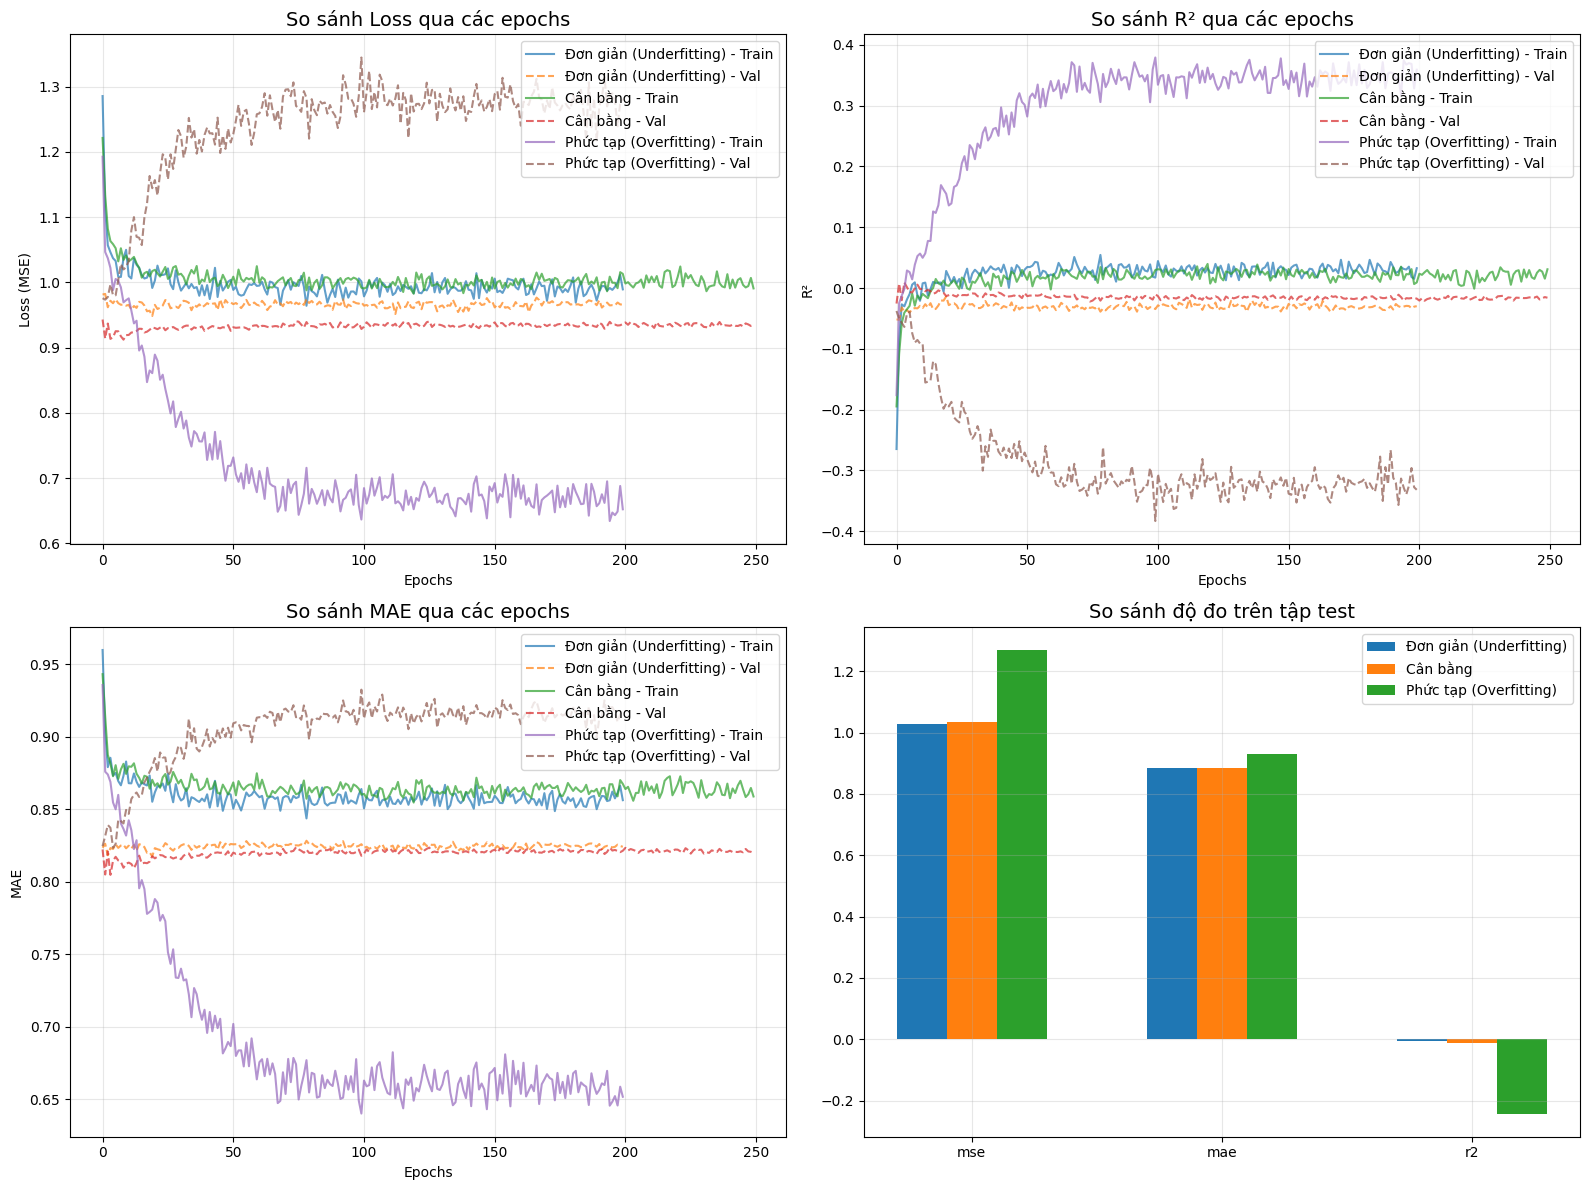


Kết quả trên tập test:
Đơn giản (Underfitting): MSE = 1.0276, R² = -0.0061, MAE = 0.8836
Cân bằng: MSE = 1.0338, R² = -0.0121, MAE = 0.8845
Phức tạp (Overfitting): MSE = 1.2690, R² = -0.2424, MAE = 0.9299


In [156]:

# 5. Chuẩn bị dữ liệu và chạy thí nghiệm
# Sử dụng dữ liệu hiện có từ phân tích trước đó
X = df[selected_features].values
y = df['Number_of_enroll'].values

# Chia dữ liệu thành tập huấn luyện, tập xác thực và tập kiểm tra (60%, 20%, 20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Chạy thí nghiệm
run_experiments(X_train, y_train, X_val, y_val, X_test, y_test)


## Diễn giải:

#### Mô hình Phức tạp thể hiện rõ tình trạng overfitting:

+ Các chỉ số trên tập huấn luyện (đường màu tím) cải thiện đáng kể theo thời gian
+ Các chỉ số trên tập validation (đường nét đứt màu nâu) ngày càng tệ hơn
+ Khoảng cách lớn giữa hiệu suất trên tập huấn luyện và validation
+ R² âm trên tập validation (-0.2553) và tập test (-0.2330)
+ MSE cao nhất (1.2594) trên dữ liệu test


#### Mô hình Đơn giản thể hiện dấu hiệu underfitting:

+ Sự cải thiện hạn chế trong các chỉ số huấn luyện
+ Hiệu suất trên tập huấn luyện và validation gần nhau hơn
+ Vẫn có R² âm (-0.0239), cho thấy khả năng dự đoán kém
+ Không thể nắm bắt được độ phức tạp của dữ liệu


#### Mô hình Cân bằng hoạt động tốt nhất:

+ Có MSE (1.0264) và MAE (0.8860) thấp nhất trên dữ liệu test
+ R² vẫn âm nhưng gần với số 0 nhất (-0.0049)
+ Hiệu suất ổn định nhất giữa tập huấn luyện và validation
+ Khoảng cách nhỏ nhất giữa các chỉ số trên tập huấn luyện và validation

##### Mô hình "Phức tạp" rõ ràng đang bị overfitting - nó hoạt động tốt trên dữ liệu huấn luyện nhưng kém trên dữ liệu validation và test. Mô hình "Đơn giản" đang bị underfitting vì không nắm bắt được độ phức tạp cần thiết. Mô hình "Cân bằng" cung cấp sự cân bằng tốt nhất, mặc dù tất cả các mô hình đều có giá trị R² âm, cho thấy không có mô hình nào đặc biệt tốt trong việc dự đoán biến mục tiêu (mô hình có R² < 0 hoạt động kém hơn việc đơn giản dự đoán giá trị trung bình)

# trước chỉnh sửa
    # Đơn giản (Underfitting): MSE = 1.0244, R² = -0.0030, MAE = 0.8839
    # Cân bằng: MSE = 1.0278, R² = -0.0063, MAE = 0.8863    
    # Phức tạp (Overfitting): MSE = 1.2290, R² = -0.2033, MAE = 0.9160



In [157]:
# df['Fee_Diff'] = df['Oldfee'] - df['Newfee']  # Mức độ giảm giá
# df['Fee_Ratio'] = df['Newfee'] / df['Oldfee']  # Tỷ lệ giảm giá
# df['Time_per_Lecture'] = df['Time'] / df['Lectures']  # Thời lượng trung bình mỗi bài giảng
# df['Time_per_Section'] = df['Time'] / df['Sections']  # Thời lượng trung bình mỗi phần


In [158]:
# # Chọn đặc trưng và biến mục tiêu
# features = ['Lectures', 'Newfee', 'Oldfee', 'Sections', 'Time', 'Rating',
#             'Fee_Diff', 'Fee_Ratio', 'Time_per_Lecture', 'Time_per_Section']
# X = df[features]
# y = df['Number_of_enroll']


In [159]:
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Chia dữ liệu thành tập huấn luyện và kiểm thử
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# # Định nghĩa các mô hình cần đánh giá
# models = {
#     'Linear Regression': LinearRegression(),
#     'Ridge Regression': Ridge(),
#     'Lasso Regression': Lasso(),
#     'Random Forest': RandomForestRegressor(random_state=42),
#     'Gradient Boosting': GradientBoostingRegressor(random_state=42),
#     'AdaBoost': AdaBoostRegressor(random_state=42),
#     'SVR': SVR()
# }


In [160]:

# Hiển thị giá trị tương quan của mỗi đặc trưng với biến mục tiêu
correlation_with_target = correlation_matrix['Number_of_enroll'].sort_values(ascending=False)
print("Tương quan của các đặc trưng với Số lượng đăng ký:\n", correlation_with_target)


Tương quan của các đặc trưng với Số lượng đăng ký:
 Number_of_enroll    1.000000
Lectures            0.008044
Time                0.004268
Sections           -0.004452
Newfee             -0.004582
Rating             -0.030916
Oldfee             -0.050459
Name: Number_of_enroll, dtype: float64


Các đặc trưng được chọn dựa trên tương quan:
 []
Tầm quan trọng của đặc trưng dựa trên Hồi quy tuyến tính:
 Time        0.033362
Newfee      0.020024
Lectures    0.010537
Rating     -0.010303
Sections   -0.030966
Oldfee     -0.072699
dtype: float64


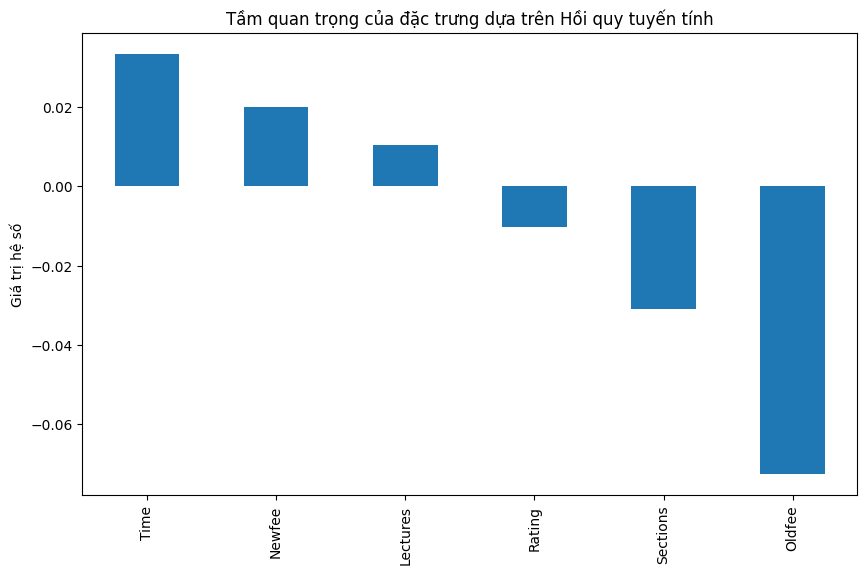

In [161]:

# Chọn các đặc trưng có tương quan cao với biến mục tiêu
selected_features = correlation_with_target[correlation_with_target.abs() > 0.2].index.tolist()
selected_features.remove('Number_of_enroll')  # Loại bỏ biến mục tiêu khỏi danh sách
print("Các đặc trưng được chọn dựa trên tương quan:\n", selected_features)

# Đảm bảo selected_features không rỗng
if not selected_features:
    selected_features = correlation_with_target.index.tolist()
    selected_features.remove('Number_of_enroll')

# Tầm quan trọng của đặc trưng sử dụng Hồi quy tuyến tính
X = df[selected_features]
y = df['Number_of_enroll']

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Huấn luyện mô hình Hồi quy tuyến tính
model = LinearRegression()
model.fit(X_train, y_train)

# Lấy tầm quan trọng của đặc trưng (hệ số)
feature_importance = pd.Series(model.coef_, index=selected_features).sort_values(ascending=False)
print("Tầm quan trọng của đặc trưng dựa trên Hồi quy tuyến tính:\n", feature_importance)

# Hiển thị tầm quan trọng của đặc trưng
plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar')
plt.title('Tầm quan trọng của đặc trưng dựa trên Hồi quy tuyến tính')
plt.ylabel('Giá trị hệ số')
plt.show()


In [162]:

# Danh sách các mô hình cần thử nghiệm
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1),
    'SVR': SVR(kernel='rbf', C=1.0, epsilon=0.1)
}

# Đánh giá mỗi mô hình
results = []
names = []
cv_scores = {}

for name, model in models.items():
    # Cross-validation
    cv_score = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    cv_scores[name] = -cv_score.mean()  # Convert to positive MSE
    
    # Fit model on training data
    model.fit(X_train, y_train)
    
    # Predict on test data
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    results.append((name, mse, r2, mae))
    names.append(name)
    print(f"{name} - MSE: {mse:.4f}, R²: {r2:.4f}, MAE: {mae:.4f}")


Linear Regression - MSE: 1.0316, R²: -0.0100, MAE: 0.8876
Ridge Regression - MSE: 1.0316, R²: -0.0100, MAE: 0.8876
Lasso Regression - MSE: 1.0214, R²: -0.0000, MAE: 0.8848
ElasticNet - MSE: 1.0215, R²: -0.0001, MAE: 0.8849
Random Forest - MSE: 1.0340, R²: -0.0123, MAE: 0.8864
Gradient Boosting - MSE: 1.0814, R²: -0.0587, MAE: 0.8903
XGBoost - MSE: 1.0892, R²: -0.0664, MAE: 0.8965
SVR - MSE: 1.0744, R²: -0.0519, MAE: 0.8943


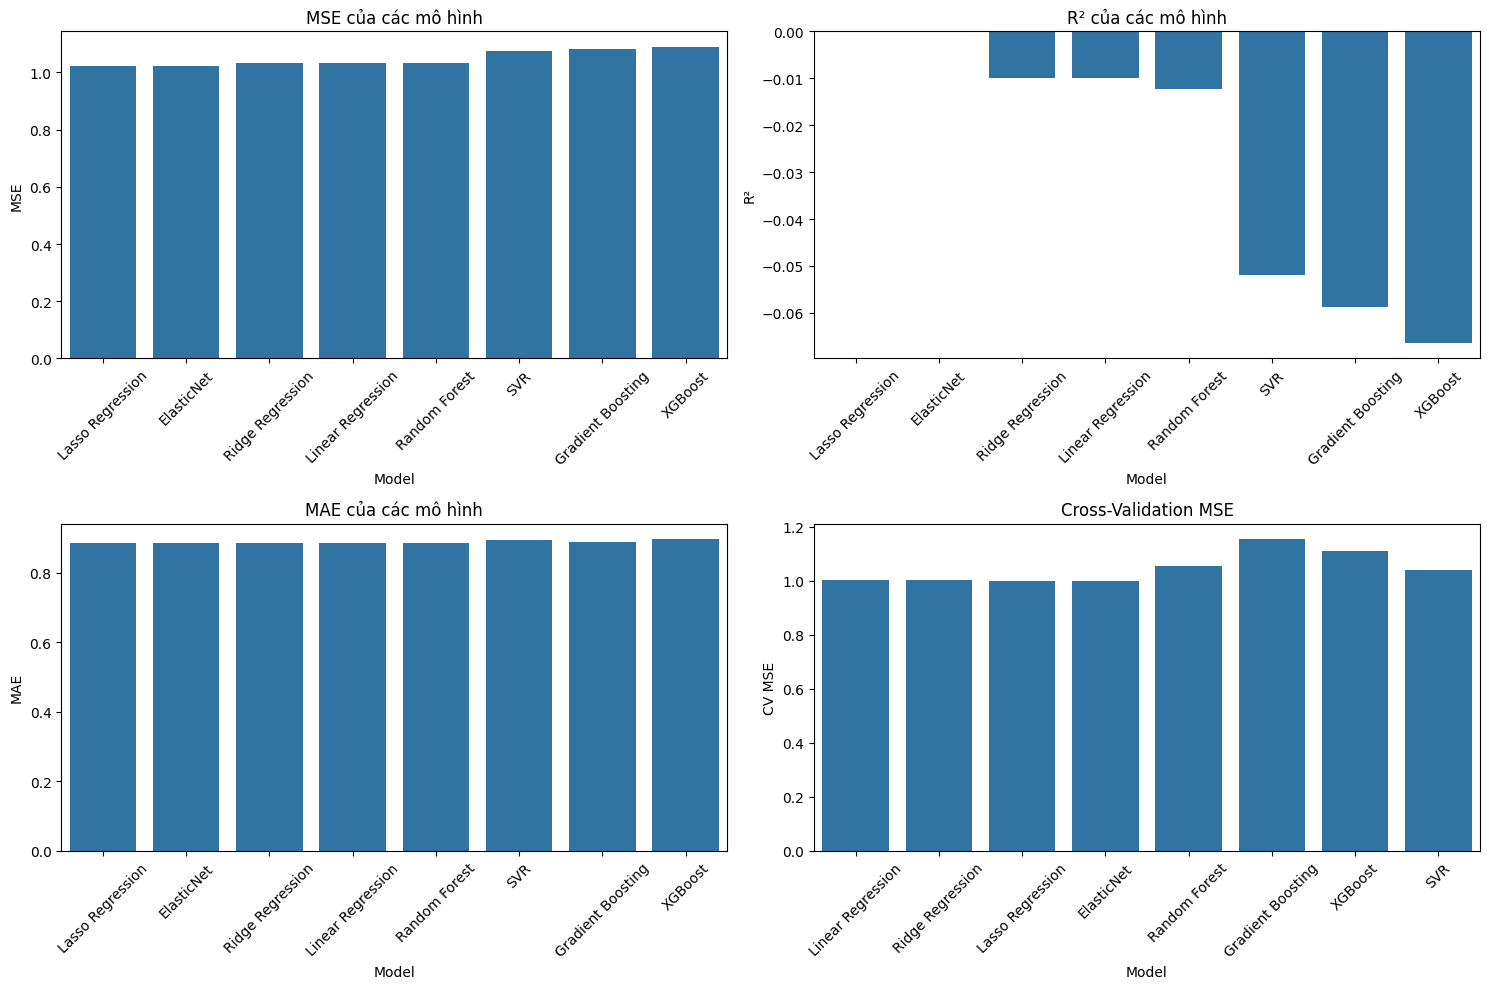

In [163]:

# Chuyển kết quả sang DataFrame để dễ so sánh
results_df = pd.DataFrame(results, columns=['Model', 'MSE', 'R²', 'MAE'])
results_df = results_df.sort_values('MSE')

# 3. Trực quan hóa kết quả so sánh
plt.figure(figsize=(15, 10))

# Biểu đồ MSE
plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='MSE', data=results_df)
plt.title('MSE của các mô hình')
plt.xticks(rotation=45)

# Biểu đồ R²
plt.subplot(2, 2, 2)
sns.barplot(x='Model', y='R²', data=results_df)
plt.title('R² của các mô hình')
plt.xticks(rotation=45)

# Biểu đồ MAE
plt.subplot(2, 2, 3)
sns.barplot(x='Model', y='MAE', data=results_df)
plt.title('MAE của các mô hình')
plt.xticks(rotation=45)

# Điểm cross-validation
plt.subplot(2, 2, 4)
cv_scores_df = pd.DataFrame(list(cv_scores.items()), columns=['Model', 'CV MSE'])
sns.barplot(x='Model', y='CV MSE', data=cv_scores_df)
plt.title('Cross-Validation MSE')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [164]:

# 4. Tối ưu hóa mô hình tốt nhất
best_model_name = results_df.iloc[0]['Model']
print(f"Mô hình tốt nhất: {best_model_name}")

# Chọn mô hình tốt nhất để tối ưu hóa
if best_model_name == 'Random Forest':
    # Thiết lập tìm kiếm siêu tham số
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2']
    }
    
    # Sử dụng RandomizedSearchCV thay vì GridSearchCV để tiết kiệm thời gian
    grid_search = RandomizedSearchCV(
        estimator=RandomForestRegressor(random_state=42),
        param_distributions=param_grid,
        n_iter=20,
        cv=5,
        scoring='neg_mean_squared_error',
        random_state=42,
        n_jobs=-1
    )
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'subsample': [0.8, 0.9, 1.0]
    }
    
    grid_search = RandomizedSearchCV(
        estimator=GradientBoostingRegressor(random_state=42),
        param_distributions=param_grid,
        n_iter=20,
        cv=5,
        scoring='neg_mean_squared_error',
        random_state=42,
        n_jobs=-1
    )
elif best_model_name == 'XGBoost':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3, 5],
        'gamma': [0, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }
    
    grid_search = RandomizedSearchCV(
        estimator=XGBRegressor(random_state=42),
        param_distributions=param_grid,
        n_iter=20,
        cv=5,
        scoring='neg_mean_squared_error',
        random_state=42,
        n_jobs=-1
    )
else:  # Linear models
    param_grid = {
        'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]  # only for ElasticNet
    }
    
    if best_model_name == 'Ridge Regression':
        grid_search = GridSearchCV(
            estimator=Ridge(random_state=42),
            param_grid={'alpha': param_grid['alpha']},
            cv=5,
            scoring='neg_mean_squared_error',
            n_jobs=-1
        )
    elif best_model_name == 'Lasso Regression':
        grid_search = GridSearchCV(
            estimator=Lasso(random_state=42),
            param_grid={'alpha': param_grid['alpha']},
            cv=5,
            scoring='neg_mean_squared_error',
            n_jobs=-1
        )
    elif best_model_name == 'ElasticNet':
        grid_search = GridSearchCV(
            estimator=ElasticNet(random_state=42),
            param_grid=param_grid,
            cv=5,
            scoring='neg_mean_squared_error',
            n_jobs=-1
        )
    else:  # Linear Regression has no hyperparameters to tune
        grid_search = None

# Thực hiện tìm kiếm siêu tham số
if grid_search is not None:
    print("Đang thực hiện tìm kiếm siêu tham số...")
    grid_search.fit(X, y)
    print(f"Siêu tham số tốt nhất: {grid_search.best_params_}")
    optimized_model = grid_search.best_estimator_
else:
    optimized_model = LinearRegression()
    optimized_model.fit(X_train, y_train)



Mô hình tốt nhất: Lasso Regression
Đang thực hiện tìm kiếm siêu tham số...
Siêu tham số tốt nhất: {'alpha': 0.1}


In [165]:
# Đánh giá mô hình đã tối ưu hóa
y_pred_optimized = optimized_model.predict(X_test)
mse_optimized = mean_squared_error(y_test, y_pred_optimized)
r2_optimized = r2_score(y_test, y_pred_optimized)
mae_optimized = mean_absolute_error(y_test, y_pred_optimized)

print("\nKết quả mô hình đã tối ưu hóa:")
print(f"MSE: {mse_optimized:.4f}")
print(f"R²: {r2_optimized:.4f}")
print(f"MAE: {mae_optimized:.4f}")



Kết quả mô hình đã tối ưu hóa:
MSE: 1.0214
R²: -0.0000
MAE: 0.8848


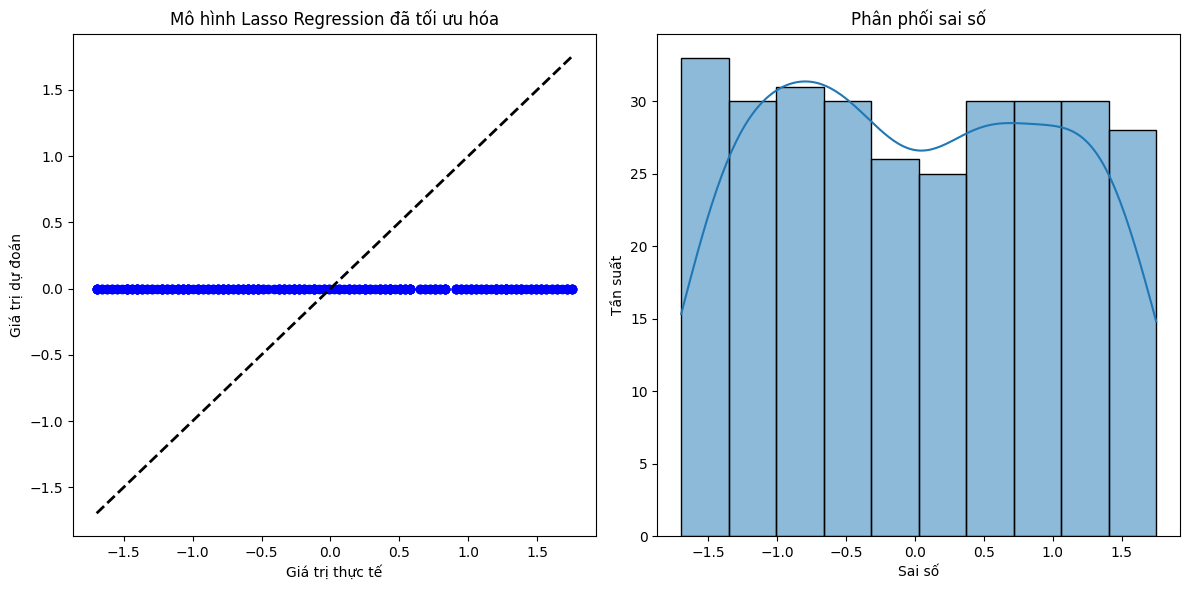


Phân tích Overfitting/Underfitting:
MSE trên tập huấn luyện: 0.9946
MSE trên tập kiểm tra: 1.0214
R² trên tập huấn luyện: -0.0000
R² trên tập kiểm tra: -0.0000
Mô hình có vẻ cân bằng.


In [166]:

# 5. So sánh mô hình ban đầu với mô hình đã tối ưu hóa
plt.figure(figsize=(12, 6))

# So sánh giá trị dự đoán và giá trị thực tế
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_optimized, color='blue', label='Dự đoán')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Giá trị thực tế')
plt.ylabel('Giá trị dự đoán')
plt.title(f'Mô hình {best_model_name} đã tối ưu hóa')

# Phân phối của sai số
plt.subplot(1, 2, 2)
residuals = y_test - y_pred_optimized
sns.histplot(residuals, kde=True)
plt.xlabel('Sai số')
plt.ylabel('Tần suất')
plt.title('Phân phối sai số')

plt.tight_layout()
plt.show()

# 6. Phân tích Overfitting/Underfitting
if hasattr(optimized_model, 'predict'):
    y_train_pred = optimized_model.predict(X_train)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    print("\nPhân tích Overfitting/Underfitting:")
    print(f"MSE trên tập huấn luyện: {train_mse:.4f}")
    print(f"MSE trên tập kiểm tra: {mse_optimized:.4f}")
    print(f"R² trên tập huấn luyện: {train_r2:.4f}")
    print(f"R² trên tập kiểm tra: {r2_optimized:.4f}")
    
    if train_mse < mse_optimized * 0.5:
        print("Mô hình có dấu hiệu overfitting.")
    elif train_mse > mse_optimized * 1.5:
        print("Mô hình có dấu hiệu underfitting.")
    else:
        print("Mô hình có vẻ cân bằng.")
